## Description:

    Ordination using PCoA
    Figure generation for manuscript
    1) Core genotypes over time for paneled figure
    2) R1 - year of release
    3) V6 Fertility
    4) R3 Fertility

    

# Init

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)
library(vegan)
library(DESeq2)
library(phyloseq)
library(MuMIn)
library(lme4)
library(lmerTest)
library(lsmeans)


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: iterators

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:gridExtra’:

    combine


  warnings.warn(x, RRuntimeWarning)
/opt/anacon

In [3]:
%%R
# set theme for ggplot

theme_pub = function (base_size = 11, base_family = "Helvetica") 
{
    theme_grey(base_size = base_size, base_family = base_family) %+replace% 
        theme(
            axis.line.x = element_line(size = .5),
            axis.line.y = element_line(size = .5),
            panel.background = element_rect(fill = "white", colour = NA), 
            panel.border = element_rect(fill = NA, color = "black", size = .5), 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), 
            legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE)
    }




 [1] "#FC8D59" "#FCA16B" "#FDB67E" "#FDCB90" "#FEDFA3" "#FEF4B5" "#F5FBBB"
 [8] "#E3F3B3" "#D0EBAB" "#BEE4A3" "#ABDC9B" "#99D594"
[1] "#FCA16B" "#FDCB90" "#FEF4B5" "#E3F3B3" "#BEE4A3" "#99D594"


# Loading phyloseq object

In [4]:
%%R
setwd('/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/')

In [5]:
%%R 
# loading

physeq = readRDS('ERA_snorm.rds')

#remove T0, not necessary
physeq = subset_samples(physeq, !is.na(Genotype), TRUE)
physeq = subset_samples(physeq, TimePoint != "T0")
physeq = transform_sample_counts(physeq, function(OTU) sqrt(OTU))
physeq = subset_samples(physeq, SeedTreatment == "Treated"| Genotype == "Bare") # see seed treatment notebook for comparison
sample_data(physeq)$Planted = ifelse(sample_data(physeq)$Genotype == "Bare", "Bare", "Rhizosphere")
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 220 samples ]
sample_data() Sample Data:       [ 220 samples by 47 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [6]:
%%R
sample_data(physeq)$Rep = as.factor(sample_data(physeq)$Rep)
sample_data(physeq)$Row = as.factor(sample_data(physeq)$Row)
sample_data(physeq)$Fert = as.factor(sample_data(physeq)$Fert)

# Core samples

In [7]:
%%R
physeq.core = subset_samples(physeq, Plant %in% c("Bare", "330", "34M95", "354", "3475", "3517", "P1151HR") & 
                             TimePoint != "T0" & Fert == "85")
physeq.core

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 84 samples ]
sample_data() Sample Data:       [ 84 samples by 47 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [8]:
%%R

# create unifrac distance matrix
registerDoParallel(cores=28)


core.bray.dist = distance(physeq.core, 
                      method = "bray", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

## adonis: rhizosphere effect in time

In [9]:
%%R
set.seed(101)

df = as(sample_data(physeq.core), "data.frame")
d = core.bray.dist
df$Fert = as.factor(df$Fert)
Fulladonis = adonis(formula = d ~ Rep + Planted + TimePoint + TimePoint:Planted, df, 
                    permutations = 999)
Fulladonis


Call:
adonis(formula = d ~ Rep + Planted + TimePoint + TimePoint:Planted,      data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                  Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Rep                3    0.2297 0.07658  1.9626 0.06110  0.001 ***
Planted            1    0.3265 0.32646  8.3667 0.08683  0.001 ***
TimePoint          2    0.2099 0.10493  2.6892 0.05582  0.001 ***
Planted:TimePoint  2    0.0675 0.03373  0.8645 0.01794  0.832    
Residuals         75    2.9264 0.03902         0.77832           
Total             83    3.7599                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [10]:
%%R
plot_ordination(physeq.core, pcoa)

NULL


In [11]:
%%R
pcoa = ordinate(physeq.core, 
                method = "PCoA", 
                distance =core.bray.dist)

p.df = plot_ordination(physeq.core, pcoa, justDF = TRUE)


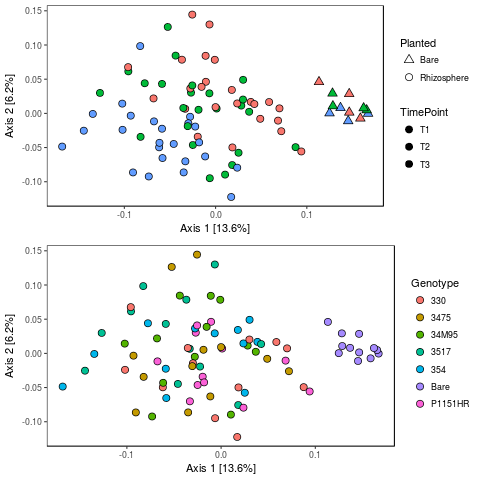

In [12]:

%%R
p = ggplot(p.df,aes(x = Axis.1, y = Axis.2)) +
        geom_point(aes(shape=Planted, fill = TimePoint), size = 3) +
    scale_shape_manual(values = c(24, 21))+
    theme_pub() +
    xlab("Axis 1 [13.6%]") +
    ylab("Axis 2 [6.2%]")

p1 = ggplot(p.df,aes(x = Axis.1, y = Axis.2)) +
        geom_point(aes( fill = Genotype), shape = 21, size = 3) +
    #scale_shape_manual(values = c(24, 21))+
    theme_pub() +
    xlab("Axis 1 [13.6%]") +
    ylab("Axis 2 [6.2%]")
        
grid.arrange(p, p1, ncol = 1)


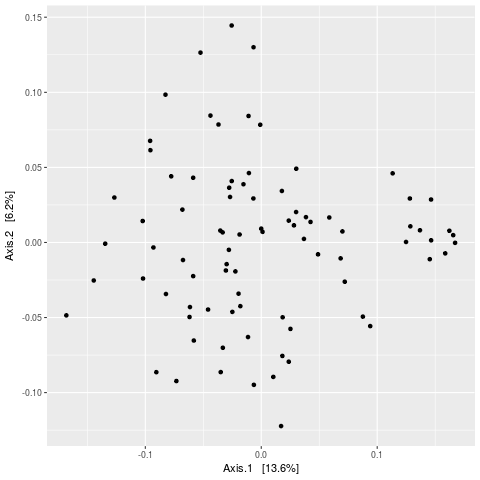

In [13]:
%%R
plot_ordination(physeq.core, pcoa)

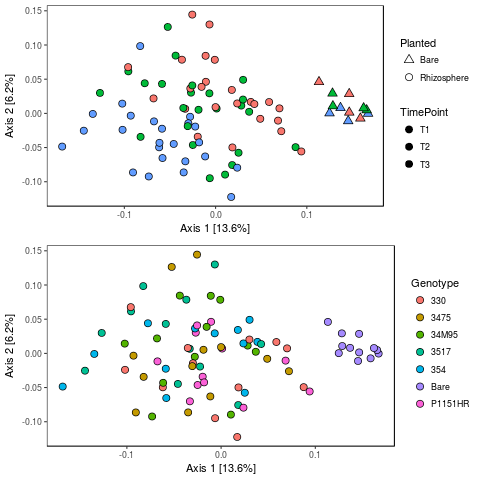

In [14]:
%%R
p = ggplot(p.df,aes(x = Axis.1, y = Axis.2)) +
        geom_point(aes(shape=Planted, fill = TimePoint), size = 3) +
    scale_shape_manual(values = c(24, 21))+
    theme_pub() +
    xlab("Axis 1 [13.6%]") +
    ylab("Axis 2 [6.2%]")

p1 = ggplot(p.df,aes(x = Axis.1, y = Axis.2)) +
        geom_point(aes( fill = Genotype), shape = 21, size = 3) +
    #scale_shape_manual(values = c(24, 21))+
    theme_pub() +
    xlab("Axis 1 [13.6%]") +
    ylab("Axis 2 [6.2%]")
        
grid.arrange(p, p1, ncol = 1)

/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:  Ignoring unknown parameters: check_overlap

  warnings.warn(x, RRuntimeWarning)


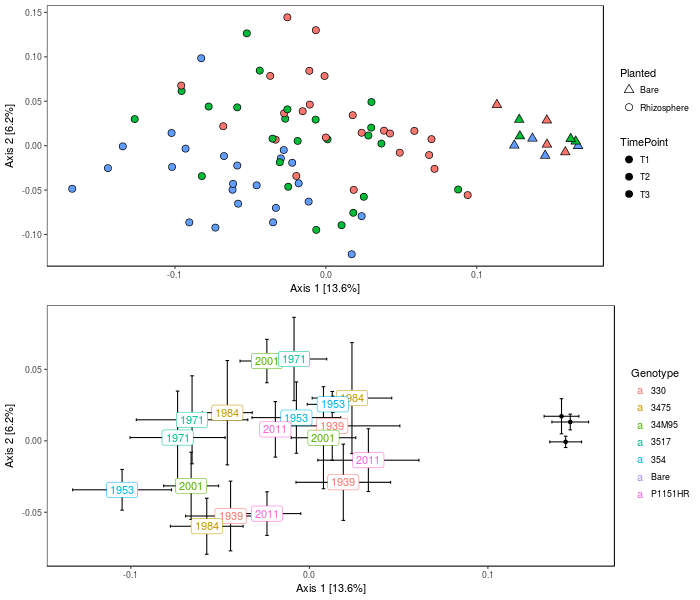

In [15]:
%%R -w 700 -h 600

p = ggplot(p.df,aes(x = Axis.1, y = Axis.2)) +
        geom_point(aes(shape=Planted, fill = TimePoint), size = 3) +
    scale_shape_manual(values = c(24, 21))+
    theme_pub() +
    xlab("Axis 1 [13.6%]") +
    ylab("Axis 2 [6.2%]")

p1 = p.df %>% group_by(Genotype, R_Year, TimePoint) %>%
    summarize(mAxis.1 = mean(Axis.1),
                seAxis.1 = sd(Axis.1)/sqrt(length(Axis.1)),
             mAxis.2 = mean(Axis.2), 
             seAxis.2 = sd(Axis.2)/sqrt(length(Axis.2))) %>%

    ggplot(., aes(x = mAxis.1, y = mAxis.2, label = R_Year)) +
    geom_point()+
    theme_pub()+
    geom_errorbar(aes(ymin = mAxis.2 - seAxis.2, ymax = mAxis.2 + seAxis.2),      
                color = "black",
                width = .002) +
    geom_errorbarh(aes(xmin = mAxis.1 - seAxis.1, xmax = mAxis.1 + seAxis.1),color = "black",
                height = .002)+
    geom_label(aes(color = Genotype), check_overlap = TRUE) + 
    xlab("Axis 1 [13.6%]") +
    ylab("Axis 2 [6.2%]")
        
grid.arrange(p, p1, ncol = 1)

## adonis: genotype effect in time 

In [16]:
%%R
rhiz.core = subset_samples(physeq, Plant %in% c("330", "34M95", "354", "3475", "3517", "P1151HR") & 
                             TimePoint != "T0" & Fert == "85")
rhiz.core

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 72 samples ]
sample_data() Sample Data:       [ 72 samples by 47 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [17]:
%%R

# create unifrac distance matrix
registerDoParallel(cores=28)


core.bray.dist = distance(rhiz.core, 
                      method = "bray", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [18]:
%%R
set.seed(101)

df = as(sample_data(rhiz.core), "data.frame")
d = core.bray.dist
df$Fert = as.factor(df$Fert)
Fulladonis = adonis(formula = d ~ Rep + TimePoint + Genotype  + Rep:TimePoint + Genotype:TimePoint , df, 
                    permutations = 999)
Fulladonis


Call:
adonis(formula = d ~ Rep + TimePoint + Genotype + Rep:TimePoint +      Genotype:TimePoint, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                   Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Rep                 3   0.22876 0.076254 1.89826 0.07246  0.001 ***
TimePoint           2   0.23288 0.116440 2.89864 0.07376  0.001 ***
Genotype            5   0.24769 0.049538 1.23320 0.07845  0.004 ** 
Rep:TimePoint       6   0.25658 0.042763 1.06453 0.08127  0.161    
TimePoint:Genotype 10   0.38366 0.038366 0.95508 0.12152  0.778    
Residuals          45   1.80767 0.040170         0.57255           
Total              71   3.15724                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# All rhizosphere samples for panel figures

In [7]:
%%R
phy.rhiz = subset_samples(physeq, Genotype != "Bare")
phy.rhiz

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 192 samples ]
sample_data() Sample Data:       [ 192 samples by 47 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


## Calculate Bray-Curtis dissimilarity between samples

In [8]:
%%R
registerDoParallel(cores=28)
bray.dist = distance(phy.rhiz, 
                      method = "bray", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [16]:
%%R
# order genotype by year
 sample_data(phy.rhiz)$Genotype = reorder(sample_data(phy.rhiz)$Genotype, sample_data(phy.rhiz)$R_Year) 
phy.rhiz %>% 
    sample_data() %>%
    .$Plant %>%
    levels()

 [1] "322"     "330"     "339"     "3394"    "3475"    "34M95"   "34N42"  
 [8] "3517"    "354"     "3541"    "3618"    "P1151HR"


## PCoA with Bray-Curtis 

In [17]:
%%R
pcoa = ordinate(phy.rhiz, 
                method = "PCoA", 
                distance =bray.dist)

p.df = plot_ordination(phy.rhiz, pcoa, justDF = TRUE)


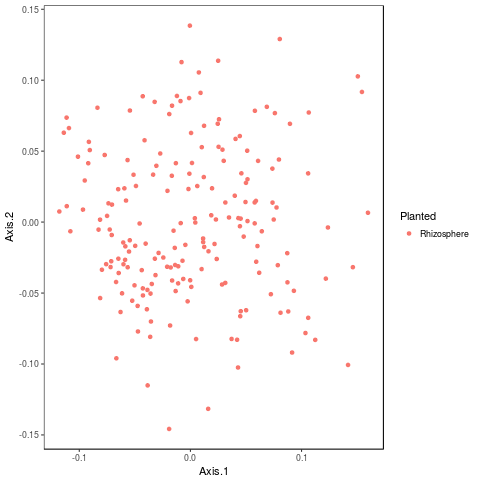

In [18]:
%%R

p = ggplot(p.df,aes(x = Axis.1, y = Axis.2)) +
        geom_point(aes(color=Planted)) +
    theme_pub()
        
p

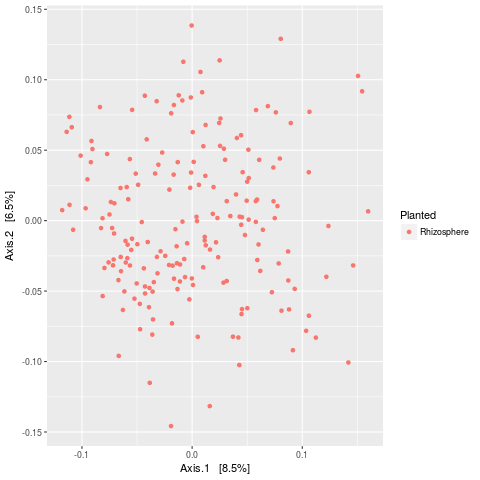

In [19]:
%%R
plot_ordination(physeq, pcoa, color = "Planted")


* Axis.1 [8.5%], Axis.2[6.5%]

### lsmeans from T1 for fertility and genotype 

In [37]:
%%R
sub = p.df %>% filter(TimePoint == "T1") %>%
    mutate(R_Year.c = R_Year - 1935)
m1= lmer(Axis.1~Genotype + Fert + (1|Rep) + (1|Pos) + (1|Pos:Fert)  + (1|Rep:Row:Pos) ,  data = sub, na.action = na.exclude)
  print("Axis1")
  anova(m1, ddf = "Kenward-Roger") %>% print

m2= lmer(Axis.2~Genotype + Fert + (1|Rep) + (1|Pos) + (1|Pos:Fert)   + (1|Rep:Row:Pos) ,  data = sub, na.action = na.exclude)
  print("Axis2")
  anova(m2, ddf = "Kenward-Roger") %>% print


[1] "Axis1"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
            Sum Sq    Mean Sq NumDF   DenDF F.value Pr(>F)
Genotype 0.0065788 0.00131576     5 12.7461 1.06392 0.4242
Fert     0.0011831 0.00059156     2  5.3897 0.47833 0.6438
[1] "Axis2"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
            Sum Sq    Mean Sq NumDF   DenDF F.value Pr(>F)
Genotype 0.0041240 0.00082479     5 12.7471 0.46096 0.7983
Fert     0.0003363 0.00016813     2  5.3897 0.09397 0.9118


In [38]:
%%R
#Generate lsmeans for fert lsm Axes at T1 

Axis1.lsm.df = lsmeans(m1, pairwise~Fert) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(Fert,lsmean,SE, lower.CL, upper.CL)

colnames(Axis1.lsm.df)[2:5] = paste("Axis1", colnames(Axis1.lsm.df)[2:5], sep = ".")

Axis2.lsm.df = lsmeans(m2, pairwise~Fert) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(Fert,lsmean, SE, lower.CL, upper.CL)

colnames(Axis2.lsm.df)[2:5] = paste("Axis2", colnames(Axis2.lsm.df)[2:5], sep = ".")

T1.fert.lsm.df = full_join(Axis1.lsm.df, Axis2.lsm.df, by = "Fert") %>%
    mutate(TimePoint = "T1")
T1.fert.lsm.df

#Generate lsmeans for genotype lsm Axes at T1 

Axis1.lsm.df = lsmeans(m1, pairwise~Genotype) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(Genotype,lsmean,SE, lower.CL, upper.CL)

colnames(Axis1.lsm.df)[2:5] = paste("Axis1", colnames(Axis1.lsm.df)[2:5], sep = ".")

Axis2.lsm.df = lsmeans(m2, pairwise~Genotype) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(Genotype,lsmean, SE, lower.CL, upper.CL)

colnames(Axis2.lsm.df)[2:5] = paste("Axis2", colnames(Axis2.lsm.df)[2:5], sep = ".")

T1.genotype.lsm.df = full_join(Axis1.lsm.df, Axis2.lsm.df, by = "Genotype") %>%
    mutate(TimePoint = "T1")
T1.genotype.lsm.df

  Genotype Axis1.lsmean   Axis1.SE Axis1.lower.CL Axis1.upper.CL Axis2.lsmean
1      330  -0.05386571 0.01233232    -0.08021072   -0.027520694  -0.01342538
2      354  -0.05924071 0.01233232    -0.08558572   -0.032895698  -0.02765131
3     3517  -0.03305063 0.01233232    -0.05939564   -0.006705619  -0.03393778
4     3475  -0.06314815 0.01233232    -0.08949316   -0.036803134  -0.01121320
5    34M95  -0.04379584 0.01233232    -0.07014085   -0.017450830  -0.02393266
6  P1151HR  -0.05461851 0.01233232    -0.08096352   -0.028273501  -0.01516114
    Axis2.SE Axis2.lower.CL Axis2.upper.CL TimePoint
1 0.01566295    -0.04758041   0.0207296461        T1
2 0.01566295    -0.06180634   0.0065037181        T1
3 0.01566295    -0.06809281   0.0002172469        T1
4 0.01566295    -0.04536822   0.0229418319        T1
5 0.01566295    -0.05808769   0.0102223647        T1
6 0.01566295    -0.04931617   0.0189938859        T1


### R_Year at T2
* test model effects

In [41]:
%%R
sub = p.df %>% filter(TimePoint == "T2") %>%
    mutate(R_Year.c = R_Year - 1935)
m1= lmer(Axis.1~poly(R_Year.c, 2) + (1|Rep) + (1|Genotype) ,  data = sub, na.action = na.exclude)
  print("Axis1")
  anova(m1, ddf = "Kenward-Roger") %>% print

m2= lmer(Axis.2~poly(R_Year.c, 2)  + (1|Rep) + (1|Genotype) ,  data = sub, na.action = na.exclude)
  print("Axis2")
  anova(m2, ddf = "Kenward-Roger") %>% print


[1] "Axis1"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                    Sum Sq   Mean Sq NumDF DenDF F.value  Pr(>F)  
poly(R_Year.c, 2) 0.010349 0.0051747     2     9  3.2382 0.08721 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "Axis2"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                    Sum Sq   Mean Sq NumDF DenDF F.value Pr(>F)
poly(R_Year.c, 2) 0.011991 0.0059955     2     9  2.7293 0.1184


In [ ]:
* Run with year as factor to get lsmeans

In [58]:
%%R
sub = p.df %>% filter(TimePoint == "T2") %>%
    mutate(R_Year.f = factor(R_Year))
m1= lmer(Axis.1~R_Year.f + (1|Rep) ,  data = sub, na.action = na.exclude)
  print("Axis1")
  anova(m1, ddf = "Kenward-Roger") %>% print

m2= lmer(Axis.2~R_Year.f  + (1|Rep)  ,  data = sub, na.action = na.exclude)
  print("Axis2")
  anova(m2, ddf = "Kenward-Roger") %>% print

[1] "Axis1"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
          Sum Sq   Mean Sq NumDF DenDF F.value  Pr(>F)  
R_Year.f 0.04487 0.0040791    11    33  2.5526 0.01847 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "Axis2"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
           Sum Sq   Mean Sq NumDF DenDF F.value Pr(>F)
R_Year.f 0.026164 0.0023786    11    33  1.0051  0.463


In [59]:
%%R
#Generate lsmeans for Axes at T1 

Axis1.lsm.df = lsmeans(m1, pairwise~R_Year.f) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(R_Year.f,lsmean,SE, lower.CL, upper.CL)%>%
        mutate(Axis = "Axis1")



Axis2.lsm.df = lsmeans(m2, pairwise~R_Year.f) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(R_Year.f,lsmean,SE, lower.CL, upper.CL) %>%
        mutate(Axis = "Axis2")

#use bind rows for plotting axes seperately and easy faceting by axis
T2.RYear.lsm.df.long = bind_rows(Axis1.lsm.df, Axis2.lsm.df)  %>%
         mutate(TimePoint = "T2", 
          R_Year = as.numeric(as.character(R_Year.f)))

#rename columns and join by rows for easy plotting of both axes in ordination
colnames(Axis1.lsm.df)[2:5] = paste("Axis1", colnames(Axis1.lsm.df)[2:5], sep = ".")
colnames(Axis2.lsm.df)[2:5] = paste("Axis2", colnames(Axis2.lsm.df)[2:5], sep = ".")

T2.RYear.lsm.df = full_join(Axis1.lsm.df[1:5], Axis2.lsm.df[1:5], by = "R_Year.f") 


T2.RYear.lsm.df

   R_Year.f Axis1.lsmean   Axis1.SE Axis1.lower.CL Axis1.upper.CL Axis2.lsmean
1      1936 -0.032673238 0.02263265   -0.079438720    0.014092244  0.032891141
2      1939 -0.032693334 0.02263265   -0.079458816    0.014072148  0.028280853
3      1942  0.042198732 0.02263265   -0.004566750    0.088964214  0.015704908
4      1953 -0.014046207 0.02263265   -0.060811689    0.032719276 -0.017816748
5      1961  0.045412899 0.02263265   -0.001352583    0.092178381  0.016840781
6      1971  0.033562040 0.02263265   -0.013203442    0.080327522 -0.018513516
7      1975  0.029839964 0.02263265   -0.016925518    0.076605446 -0.046051988
8      1984  0.022277759 0.02263265   -0.024487724    0.069043241 -0.028887900
9      1991  0.009426982 0.02263265   -0.037338500    0.056192464  0.014117490
10     2001 -0.026318516 0.02263265   -0.073083998    0.020446966  0.001609444
11     2003 -0.042752298 0.02263265   -0.089517781    0.004013184  0.009771070
12     2011 -0.002089749 0.02263265   -0.048855231  

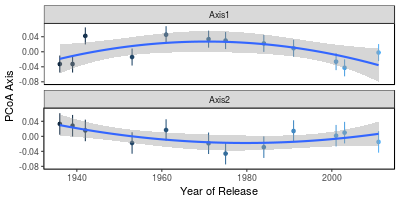

In [60]:
%%R -w 400 -h 200
pF = ggplot(T2.RYear.lsm.df.long, aes(x = R_Year, y = lsmean, color = R_Year)) +
    geom_point()+
    theme_pub()+
    geom_errorbar(aes(ymin = lsmean - SE , ymax = lsmean + SE , color = R_Year),      
                width = .002) +
    #xlim(c(-0.06, 0.09)) +
 
    theme(legend.position = "none")+
    xlab("Year of Release")+
    ylab("PCoA Axis")+
    stat_smooth(method = "lm", formula = y ~poly(x,2)) +
   facet_wrap(~Axis, ncol = 1) 

pF


### Generate lsmeans for fertility and genotype at T3

In [39]:
%%R
sub = p.df %>% filter(TimePoint == "T3") 
m1= lmer(Axis.1~Genotype + Fert + (1|Rep) + (1|Pos) + (1|Pos:Fert)  + (1|Rep:Row:Pos) ,  data = sub, na.action = na.exclude)
  print("Axis1")
  anova(m1, ddf = "Kenward-Roger") %>% print

m2= lmer(Axis.2~Genotype + Fert + (1|Rep) + (1|Pos) + (1|Pos:Fert)  + (1|Rep:Row:Pos) ,  data = sub, na.action = na.exclude)
  print("Axis2")
  anova(m2, ddf = "Kenward-Roger") %>% print


[1] "Axis1"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
            Sum Sq   Mean Sq NumDF   DenDF F.value  Pr(>F)  
Genotype 0.0031519 0.0006304     5 12.8677  0.4498 0.80610  
Fert     0.0273925 0.0136963     2  5.3897  9.7719 0.01612 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "Axis2"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
            Sum Sq   Mean Sq NumDF   DenDF F.value Pr(>F)
Genotype 0.0167076 0.0033415     5 12.7184  1.8152 0.1804
Fert     0.0003722 0.0001861     2  5.3897  0.1011 0.9055


In [40]:
%%R
#Generate lsmeans for fert lsm Axes at T3 

Axis1.lsm.df = lsmeans(m1, pairwise~Fert) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(Fert,lsmean,SE, lower.CL, upper.CL)

colnames(Axis1.lsm.df)[2:5] = paste("Axis1", colnames(Axis1.lsm.df)[2:5], sep = ".")

Axis2.lsm.df = lsmeans(m2, pairwise~Fert) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(Fert,lsmean, SE, lower.CL, upper.CL)

colnames(Axis2.lsm.df)[2:5] = paste("Axis2", colnames(Axis2.lsm.df)[2:5], sep = ".")

T3.fert.lsm.df = full_join(Axis1.lsm.df, Axis2.lsm.df, by = "Fert") %>%
    mutate(TimePoint = "T3")
T3.fert.lsm.df

#Generate lsmeans for genotype lsm Axes at T3 

Axis1.lsm.df = lsmeans(m1, pairwise~Genotype) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(Genotype,lsmean,SE, lower.CL, upper.CL)

colnames(Axis1.lsm.df)[2:5] = paste("Axis1", colnames(Axis1.lsm.df)[2:5], sep = ".")

Axis2.lsm.df = lsmeans(m2, pairwise~Genotype) %>% 
        summary %>%
        .$lsmeans %>%
        as.data.frame() %>%
        select(Genotype,lsmean, SE, lower.CL, upper.CL)

colnames(Axis2.lsm.df)[2:5] = paste("Axis2", colnames(Axis2.lsm.df)[2:5], sep = ".")

T3.genotype.lsm.df = full_join(Axis1.lsm.df, Axis2.lsm.df, by = "Genotype") %>%
    mutate(TimePoint = "T1")
T3.genotype.lsm.df

  Genotype Axis1.lsmean   Axis1.SE Axis1.lower.CL Axis1.upper.CL Axis2.lsmean
1      330   0.04154605 0.01413509    0.011689594     0.07140252   0.02411740
2      354   0.05899544 0.01413509    0.029138980     0.08885190  -0.01114353
3     3517   0.05938330 0.01413509    0.029526834     0.08923976   0.01172640
4     3475   0.05700726 0.01413509    0.027150799     0.08686372   0.05656697
5    34M95   0.04128848 0.01413509    0.011432015     0.07114494   0.02093533
6  P1151HR   0.03878401 0.01413509    0.008927548     0.06864047   0.02541702
    Axis2.SE Axis2.lower.CL Axis2.upper.CL TimePoint
1 0.02022777    -0.02100357     0.06923837        T1
2 0.02022777    -0.05626450     0.03397744        T1
3 0.02022777    -0.03339457     0.05684737        T1
4 0.02022777     0.01144600     0.10168794        T1
5 0.02022777    -0.02418564     0.06605631        T1
6 0.02022777    -0.01970395     0.07053799        T1


In [67]:
%%R
Fert.lsm = bind_rows(T1.lsm.df, T3.lsm.df)

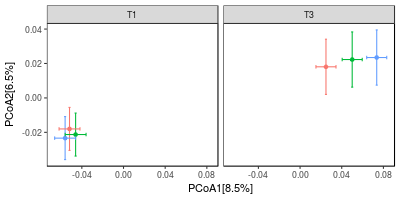

In [71]:
%%R -w 400 -h 200
pF = ggplot(Fert.lsm, aes(x = Axis1.lsmean, y = Axis2.lsmean, color = Fert)) +
    geom_point()+
    theme_pub()+
    geom_errorbar(aes(ymin = Axis2.lsmean - Axis2.SE, ymax = Axis2.lsmean + Axis2.SE, color = Fert),      
                width = .002) +
    geom_errorbarh(aes(xmin = Axis1.lsmean - Axis1.SE, xmax = Axis1.lsmean + Axis1.SE, color = Fert),
                height = .002) +
    theme(legend.position = "none")+
    xlab("PCoA1[8.5%]")+
    ylab("PCoA2[6.5%]")+
   facet_wrap(~TimePoint)

pF

* Get genotype coefficients by using R_Year as a factor

## Plot and arrange ordination figure

In [51]:
%%R
T1.genotype.lsm.df

  Genotype Axis1.lsmean   Axis1.SE Axis1.lower.CL Axis1.upper.CL Axis2.lsmean
1      330  -0.05386571 0.01233232    -0.08021072   -0.027520694  -0.01342538
2      354  -0.05924071 0.01233232    -0.08558572   -0.032895698  -0.02765131
3     3517  -0.03305063 0.01233232    -0.05939564   -0.006705619  -0.03393778
4     3475  -0.06314815 0.01233232    -0.08949316   -0.036803134  -0.01121320
5    34M95  -0.04379584 0.01233232    -0.07014085   -0.017450830  -0.02393266
6  P1151HR  -0.05461851 0.01233232    -0.08096352   -0.028273501  -0.01516114
    Axis2.SE Axis2.lower.CL Axis2.upper.CL TimePoint
1 0.01566295    -0.04758041   0.0207296461        T1
2 0.01566295    -0.06180634   0.0065037181        T1
3 0.01566295    -0.06809281   0.0002172469        T1
4 0.01566295    -0.04536822   0.0229418319        T1
5 0.01566295    -0.05808769   0.0102223647        T1
6 0.01566295    -0.04931617   0.0189938859        T1


In [111]:
%%R
#set color scales
library(RColorBrewer)
FertColors = brewer.pal(3, 'YlOrRd')

GenotypeColors = colorRampPalette(brewer.pal(11,'RdYlBu'))(12)
GenotypeColors %>% print

GenotypeColors_sub6 = GenotypeColors[c(2,4,6,8,10,12)]
GenotypeColors_sub6 

 [1] "#A50026" "#D22B26" "#EE613D" "#FA9C58" "#FDCD7E" "#FEF0A9" "#F0F9D8"
 [8] "#CCE9F2" "#9CCDE2" "#6BA2CB" "#436FB1" "#313695"
[1] "#D22B26" "#FA9C58" "#FEF0A9" "#CCE9F2" "#6BA2CB" "#313695"


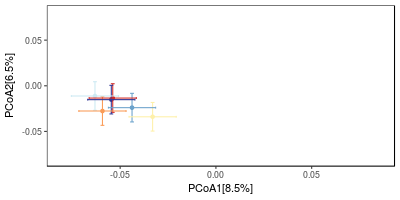

In [120]:
%%R -w 400 -h 200
pG1 = ggplot(T1.genotype.lsm.df, aes(x = Axis1.lsmean, y = Axis2.lsmean, color = Genotype)) +
    scale_color_manual(values = c(GenotypeColors_sub6))+
    geom_point()+
    theme_pub()+
    geom_errorbar(aes(ymin = Axis2.lsmean - Axis2.SE, ymax = Axis2.lsmean + Axis2.SE, color = Genotype),      
                width = .002) +
    geom_errorbarh(aes(xmin = Axis1.lsmean - Axis1.SE, xmax = Axis1.lsmean + Axis1.SE, color = Genotype),
                height = .002) +
    theme(legend.position = "none")+
    xlab("PCoA1[8.5%]")+
    ylab("PCoA2[6.5%]")+
      xlim(c(-0.08, 0.085))+
    ylim(c(-0.08,0.08))

pG1

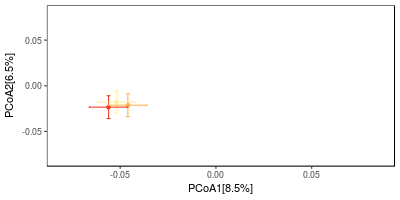

In [114]:
%%R -w 400 -h 200
pF1 = ggplot(T1.fert.lsm.df, aes(x = Axis1.lsmean, y = Axis2.lsmean, color = Fert)) +
    geom_point()+
    scale_color_manual(values = c(FertColors))+
    theme_pub()+
    geom_errorbar(aes(ymin = Axis2.lsmean - Axis2.SE, ymax = Axis2.lsmean + Axis2.SE, color = Fert),      
                width = .002) +
    geom_errorbarh(aes(xmin = Axis1.lsmean - Axis1.SE, xmax = Axis1.lsmean + Axis1.SE, color = Fert),
                height = .002) +
    theme(legend.position = "none")+
    xlab("PCoA1[8.5%]")+
    ylab("PCoA2[6.5%]")+
      xlim(c(-0.08, 0.085))+
    ylim(c(-0.08,0.08))

pF1

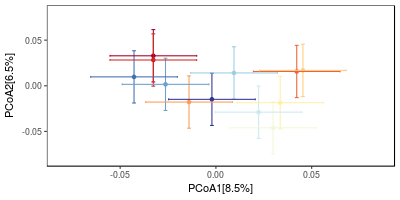

In [115]:
%%R -w 400 -h 200
pG2 = ggplot(T2.RYear.lsm.df, aes(x = Axis1.lsmean, y = Axis2.lsmean, color = R_Year.f)) +
    scale_color_manual(values = c(GenotypeColors))+
    geom_point()+
    theme_pub()+
    geom_errorbar(aes(ymin = Axis2.lsmean - Axis2.SE, ymax = Axis2.lsmean + Axis2.SE, color = R_Year.f),      
                width = .002) +
    geom_errorbarh(aes(xmin = Axis1.lsmean - Axis1.SE, xmax = Axis1.lsmean + Axis1.SE, color = R_Year.f),
                height = .002) +
    theme(legend.position = "none")+
    xlab("PCoA1[8.5%]")+
    ylab("PCoA2[6.5%]")+
     xlim(c(-0.08, 0.085))+
    ylim(c(-0.08,0.08))

pG2

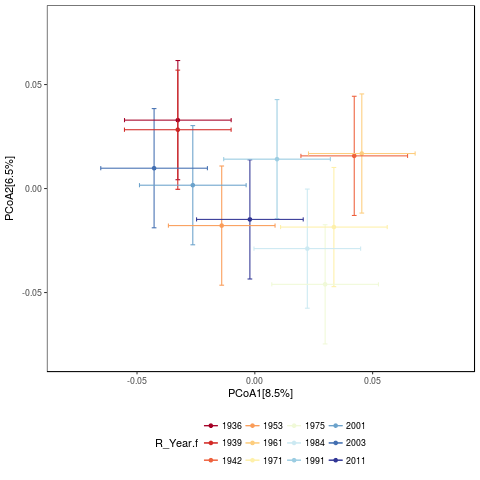

In [121]:
%%R 
# Just to gather legend
ggplot(T2.RYear.lsm.df, aes(x = Axis1.lsmean, y = Axis2.lsmean, color = R_Year.f)) +
    scale_color_manual(values = c(GenotypeColors))+
    geom_point()+
    theme_pub()+
    geom_errorbar(aes(ymin = Axis2.lsmean - Axis2.SE, ymax = Axis2.lsmean + Axis2.SE, color = R_Year.f),      
                width = .002) +
    geom_errorbarh(aes(xmin = Axis1.lsmean - Axis1.SE, xmax = Axis1.lsmean + Axis1.SE, color = R_Year.f),
                height = .002) +
    theme(legend.position = "bottom")+
    xlab("PCoA1[8.5%]")+
    ylab("PCoA2[6.5%]")+
     xlim(c(-0.08, 0.085))+
    ylim(c(-0.08,0.08))


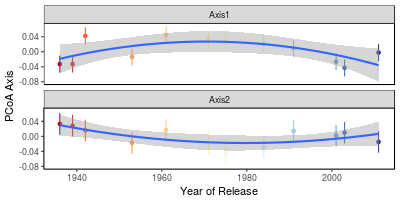

In [116]:
%%R -w 400 -h 200
pY2 = ggplot(T2.RYear.lsm.df.long, aes(x = R_Year, y = lsmean)) +
    geom_point(aes(color = R_Year.f))+
    theme_pub()+
    geom_errorbar(aes(ymin = lsmean - SE , ymax = lsmean + SE , color = R_Year.f),      
                width = .002) +
    scale_color_manual(values = c(GenotypeColors))+
    #xlim(c(-0.06, 0.09)) +
 
    theme(legend.position = "none")+
    xlab("Year of Release")+
    ylab("PCoA Axis")+
    stat_smooth(method = "lm", formula = y ~poly(x,2)) +
   facet_wrap(~Axis, ncol = 1) 

pY2

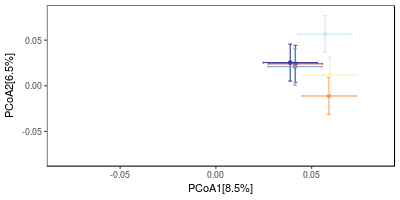

In [117]:
%%R -w 400 -h 200
pG3 = ggplot(T3.genotype.lsm.df, aes(x = Axis1.lsmean, y = Axis2.lsmean, color = Genotype)) +
    scale_color_manual(values = c(GenotypeColors_sub6))+
    geom_point()+
    theme_pub()+
    geom_errorbar(aes(ymin = Axis2.lsmean - Axis2.SE, ymax = Axis2.lsmean + Axis2.SE, color = Genotype),      
                width = .002) +
    geom_errorbarh(aes(xmin = Axis1.lsmean - Axis1.SE, xmax = Axis1.lsmean + Axis1.SE, color = Genotype),
                height = .002) +
    theme(legend.position = "none")+
    xlab("PCoA1[8.5%]")+
    ylab("PCoA2[6.5%]")+
     xlim(c(-0.08, 0.085))+
    ylim(c(-0.08,0.08))

pG3

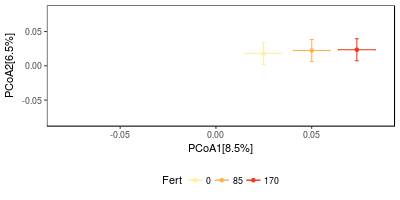

In [123]:
%%R -w 400 -h 200
pF3 = ggplot(T3.fert.lsm.df, aes(x = Axis1.lsmean, y = Axis2.lsmean, color = Fert)) +
    scale_color_manual(values = c(FertColors))+
    geom_point()+
    theme_pub()+
    geom_errorbar(aes(ymin = Axis2.lsmean - Axis2.SE, ymax = Axis2.lsmean + Axis2.SE, color = Fert),      
                width = .002) +
    geom_errorbarh(aes(xmin = Axis1.lsmean - Axis1.SE, xmax = Axis1.lsmean + Axis1.SE, color = Fert),
                height = .002) +
    theme(legend.position = "bottom")+
    xlab("PCoA1[8.5%]")+
    ylab("PCoA2[6.5%]")+
      xlim(c(-0.08, 0.085))+
    ylim(c(-0.08,0.08))

pF3 %>% print
pF3 = pF3 + theme(legend.position = "none")

### Arrange plots

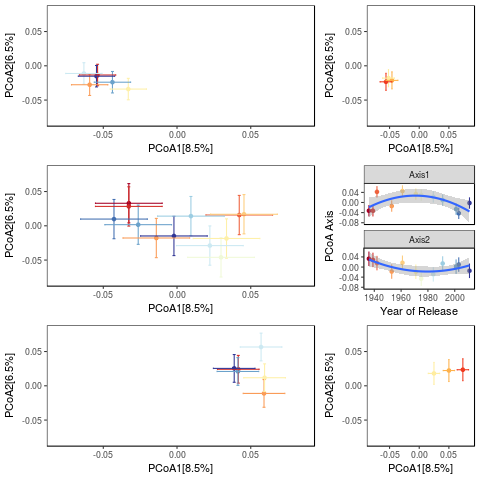

In [126]:
%%R
#layout = rbind(c(1,1,1,2,2,2), c(3,3,3,3,4,4), c(5,5,5,6,6,6))
layout = rbind(c(1,1,2), c(3,3,4), c(5,5,6))
grid.arrange(pG1, pF1, pG2, pY2, pG3, pF3, layout_matrix = layout)

# NMDS of global data faceted by sampling date

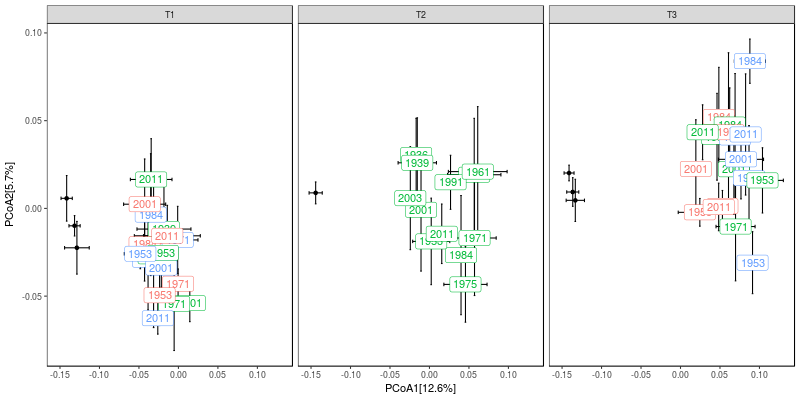

In [244]:
%%R -w 800 -h 400
pF = ggplot(ordMean, aes(x = mAxis.1, y = mAxis.2, label = R_Year)) +
    geom_point()+
    theme_pub()+
    geom_errorbar(aes(ymin = mAxis.2 - seAxis.2, ymax = mAxis.2 + seAxis.2),      
                color = "black",
                width = .002) +
    geom_errorbarh(aes(xmin = mAxis.1 - seAxis.1, xmax = mAxis.1 + seAxis.1),color = "black",
                height = .002)+
    geom_label(aes(color = Fert), check_overlap = TRUE) +
    theme(legend.position = "none")+
    xlab("PCoA1[12.6%]")+
    ylab("PCoA2[5.7%]")+
   facet_wrap(~TimePoint)

pF

### Closer look at T2

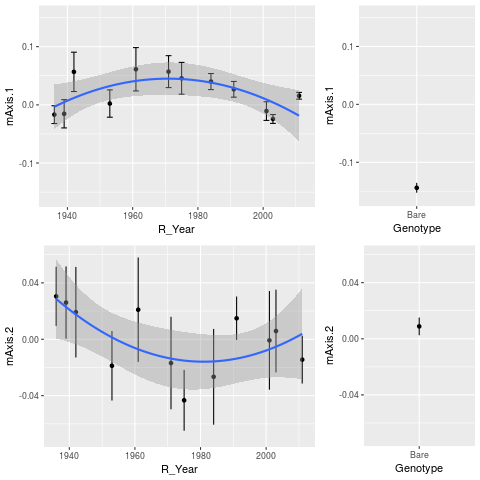

In [245]:
%%R
p1 = ggplot(subset(ordMean, TimePoint == "T2"), aes(x = R_Year, y = mAxis.1)) +
    geom_point() +
    ylim(c(-0.16, 0.155))+
     geom_errorbar(aes(ymin = mAxis.1 - seAxis.1, ymax = mAxis.1 + seAxis.1),color = "black",
                height = .002)+
    stat_smooth(method = "lm", formula = y ~ poly(x,2))

p2 =    ggplot(subset(ordMean, TimePoint == "T2"), aes(x = R_Year, y = mAxis.2)) +
    geom_point() +
     geom_errorbar(aes(ymin = mAxis.2 - seAxis.2, ymax = mAxis.2 + seAxis.2),      
                color = "black",
                width = .002)+
    ylim(c(-0.07, 0.06))+
    stat_smooth(method = "lm", formula = y ~ poly(x,2))


    stat_smooth(method = "lm", formula = y ~ poly(x,2))
p3 =    ggplot(subset(ordMean, TimePoint == "T2" & Genotype == "Bare"), aes(x = Genotype, y = mAxis.1)) +
    geom_point() +
    ylim(c(-0.16, 0.155))+
     geom_errorbar(aes(ymin = mAxis.1- seAxis.1, ymax = mAxis.1 + seAxis.1),      
                color = "black",
                width = .002)+
    stat_smooth(method = "lm", formula = y ~ poly(x,2))

p4 =    ggplot(subset(ordMean, TimePoint == "T2" & Genotype == "Bare"), aes(x = Genotype, y = mAxis.2)) +
    geom_point() +
    ylim(c(-0.07, 0.06))+
     geom_errorbar(aes(ymin = mAxis.2 - seAxis.2, ymax = mAxis.2 + seAxis.2),      
                color = "black",
                width = .002)+
    stat_smooth(method = "lm", formula = y ~ poly(x,2))

grid.arrange(p1, p3, p2,p4,  ncol = 2, widths = c(2,1))

### PCOA~RYear

* Axis 1

In [246]:
%%R
# on raw data
tmp = p.df %>% filter(TimePoint == "T2" & Genotype != "Bare")
m = lmer(Axis.1~poly(R_Year,2) + (1|Rep) + (1|Genotype), data = tmp)
anova(m) %>% print
summary(m)

Analysis of Variance Table of type III  with  Satterthwaite 
approximation for degrees of freedom
                 Sum Sq   Mean Sq NumDF DenDF F.value  Pr(>F)  
poly(R_Year, 2) 0.01113 0.0055649     2     9  3.4502 0.07722 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: Axis.1 ~ poly(R_Year, 2) + (1 | Rep) + (1 | Genotype)
   Data: tmp

REML criterion at convergence: -148.3

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.09552 -0.50822 -0.08453  0.29658  2.70850 

Random effects:
 Groups   Name        Variance  Std.Dev.
 Genotype (Intercept) 0.0003111 0.01764 
 Rep      (Intercept) 0.0004300 0.02074 
 Residual             0.0016129 0.04016 
Number of obs: 48, groups:  Genotype, 12; Rep, 4

Fixed effects:
                 Estimate Std. Error       df t value Pr(>|t|)  
(Intercept)       0.01981    0.01292  3.94900   1.533   0.2009 

In [247]:
%%R
r.squaredGLMM(m)

      R2m       R2c 
0.1512583 0.4184643 


* Axis 2 

In [248]:
%%R
# on raw data
tmp = p.df %>% filter(TimePoint == "T2" & Genotype != "Bare")
m = lmer(Axis.2~poly(R_Year,2) + (1|Rep) + (1|Genotype), data = tmp)
anova(m) %>% print
summary(m)

Analysis of Variance Table of type III  with  Satterthwaite 
approximation for degrees of freedom
                  Sum Sq   Mean Sq NumDF DenDF F.value  Pr(>F)  
poly(R_Year, 2) 0.010585 0.0052923     2    42  2.5097 0.09341 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: Axis.2 ~ poly(R_Year, 2) + (1 | Rep) + (1 | Genotype)
   Data: tmp

REML criterion at convergence: -140.3

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.81122 -0.72545  0.03988  0.75122  2.16516 

Random effects:
 Groups   Name        Variance  Std.Dev.
 Genotype (Intercept) 0.0000000 0.00000 
 Rep      (Intercept) 0.0008846 0.02974 
 Residual             0.0021087 0.04592 
Number of obs: 48, groups:  Genotype, 12; Rep, 4

Fixed effects:
                   Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)      -0.0003057  0.0162814  3.0000000  -0.019

In [249]:
%%R
r.squaredGLMM(m)

       R2m        R2c 
0.06997175 0.34481957 


## At each timepoint

### T1

In [138]:
%%R
phy.c.t = subset_samples(physeq, Plant %in% c("330", "34M95", "354", "3475", "3517", "P1151HR") & 
                             TimePoint == "T1" & Fert == "85")
phy.c.t

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 24 samples ]
sample_data() Sample Data:       [ 24 samples by 47 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [139]:
%%R

# create unifrac distance matrix
registerDoParallel(cores=28)
c.t.dist = distance(phy.c.t, 
                      method = "bray", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#Adonis
set.seed(101)

df = as(sample_data(phy.c.t), "data.frame")
d = c.t.dist
print("Bray-curtis")
Coreadonis = adonis(formula = d ~ Rep + Genotype, df, permutations = 999)
Coreadonis %>% print

[1] "Bray-curtis"

Call:
adonis(formula = d ~ Rep + Genotype, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)  
Rep        3   0.15857 0.052858  1.2447 0.15729  0.015 *
Genotype   5   0.21258 0.042517  1.0012 0.21087  0.481  
Residuals 15   0.63698 0.042465         0.63184         
Total     23   1.00814                  1.00000         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### T2

In [141]:
%%R
phy.c.t = subset_samples(physeq, Plant %in% c("330", "34M95", "354", "3475", "3517", "P1151HR") & 
                             TimePoint == "T2" & Fert == "85")
phy.c.t

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 24 samples ]
sample_data() Sample Data:       [ 24 samples by 47 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [142]:
%%R

# create unifrac distance matrix
registerDoParallel(cores=28)
c.t.dist = distance(phy.c.t, 
                      method = "bray", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#Adonis
set.seed(101)

df = as(sample_data(phy.c.t), "data.frame")
d = c.t.dist
print("Bray-curtis")
Coreadonis = adonis(formula = d ~ Rep + Genotype, df, permutations = 999)
Coreadonis %>% print

[1] "Bray-curtis"

Call:
adonis(formula = d ~ Rep + Genotype, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Rep        3   0.17622 0.058740  1.5426 0.18478  0.001 ***
Genotype   5   0.20624 0.041249  1.0832 0.21627  0.151    
Residuals 15   0.57119 0.038079         0.59895           
Total     23   0.95365                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### T3

In [143]:
%%R
phy.c.t = subset_samples(physeq, Plant %in% c("330", "34M95", "354", "3475", "3517", "P1151HR") & 
                             TimePoint == "T3" & Fert == "85")
phy.c.t

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 24 samples ]
sample_data() Sample Data:       [ 24 samples by 47 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [144]:
%%R

# create unifrac distance matrix
registerDoParallel(cores=28)
c.t.dist = distance(phy.c.t, 
                      method = "bray", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#Adonis
set.seed(101)

df = as(sample_data(phy.c.t), "data.frame")
d = c.t.dist
print("Bray-curtis")
Coreadonis = adonis(formula = d ~ Rep + Genotype, df, permutations = 999)
Coreadonis %>% print

[1] "Bray-curtis"

Call:
adonis(formula = d ~ Rep + Genotype, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)   
Rep        3   0.15055 0.050182  1.2556 0.15640  0.003 **
Genotype   5   0.21253 0.042505  1.0635 0.22079  0.167   
Residuals 15   0.59950 0.039967         0.62281          
Total     23   0.96257                  1.00000          
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# --Sandbox--

In [145]:
%%R
## generating plots
p1 = ggplot(p.F, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=R_Year), pch = 21, size = 3)
        #scale_size(range=c(2,8))

#p2 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        #geom_point(aes(fill=Plant, size = BD), pch=21) +
        #scale_size(range=c(2,8))

grid.arrange(p1, ncol=1)


Error in ggplot(p.F, aes(x = NMDS1, y = NMDS2)) : object 'p.F' not found


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in ggplot(p.F, aes(x = NMDS1, y = NMDS2)) : object 'p.F' not found

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 1: Removed 7 rows containing missing values (geom_label). 

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 2: Removed 1 rows containing non-finite values (stat_smooth). 

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 3: Removed 1 rows containing missing values (geom_point). 

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RR

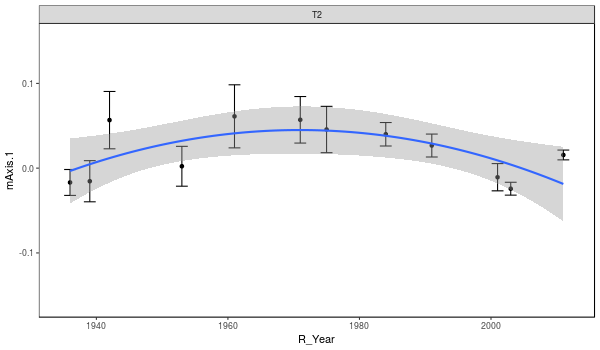

In [146]:
%%R -w 600 -h 350
p2 = p1 + facet_wrap(~TimePoint)+
theme_pub()
p2

In [147]:
# Create faceted figure with full dataset

# Adonis sampling date by rhizosphere effect

In [148]:
%%R
phy.core = subset_samples(physeq, Genotype %in% c("Bare","330", "354", "3517", "3475", "34M95", "P1151HR") &
                         Fert == "85"  & TimePoint != "T0")

In [149]:
%%R
sample_data(phy.core)$Planted

 [1] "Rhizosphere" "Bare"        "Rhizosphere" "Rhizosphere" "Rhizosphere"
 [6] "Rhizosphere" "Bare"        "Rhizosphere" "Rhizosphere" "Rhizosphere"
[11] "Rhizosphere" "Rhizosphere" "Rhizosphere" "Rhizosphere" "Bare"       
[16] "Rhizosphere" "Bare"        "Rhizosphere" "Rhizosphere" "Rhizosphere"
[21] "Rhizosphere" "Rhizosphere" "Bare"        "Rhizosphere" "Bare"       
[26] "Rhizosphere" "Rhizosphere" "Rhizosphere" "Rhizosphere" "Rhizosphere"
[31] "Rhizosphere" "Rhizosphere" "Rhizosphere" "Rhizosphere" "Rhizosphere"
[36] "Bare"        "Rhizosphere" "Rhizosphere" "Rhizosphere" "Rhizosphere"
[41] "Rhizosphere" "Rhizosphere" "Rhizosphere" "Rhizosphere" "Rhizosphere"
[46] "Rhizosphere" "Rhizosphere" "Rhizosphere" "Bare"        "Rhizosphere"
[51] "Rhizosphere" "Rhizosphere" "Rhizosphere" "Rhizosphere" "Rhizosphere"
[56] "Rhizosphere" "Rhizosphere" "Rhizosphere" "Rhizosphere" "Rhizosphere"
[61] "Rhizosphere" "Rhizosphere" "Rhizosphere" "Bare"        "Rhizosphere"
[66] "Rhizosphere" "Rhizo

In [150]:
%%R
registerDoParallel(cores=28)
bray.dist = distance(phy.core, 
                      method = "bray", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


In [151]:
%%R
set.seed(101)

df = as(sample_data(phy.core), "data.frame")
d = bray.dist
df$Fert = as.factor(df$Fert)
Fulladonis = adonis(formula = d ~ Rep + Planted + Genotype + TimePoint + Planted:TimePoint + Genotype:TimePoint, df, 
                    permutations = 999)
Fulladonis


Call:
adonis(formula = d ~ Rep + Planted + Genotype + TimePoint + Planted:TimePoint +      Genotype:TimePoint, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                   Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Rep                 3    0.2297 0.07658  2.0020 0.06110  0.001 ***
Planted             1    0.3265 0.32646  8.5347 0.08683  0.001 ***
Genotype            5    0.2477 0.04954  1.2951 0.06588  0.012 *  
TimePoint           2    0.2099 0.10493  2.7432 0.05582  0.001 ***
Planted:TimePoint   2    0.0675 0.03373  0.8818 0.01794  0.772    
Genotype:TimePoint 10    0.3837 0.03837  1.0030 0.10204  0.440    
Residuals          60    2.2950 0.03825         0.61040           
Total              83    3.7599                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# Dissimiliarity by time point

## T1 adonis

In [152]:
%%R
physeq.plantT1 = subset_samples(physeq,  Planted == "Rhizosphere" & TimePoint == "T1")
physeq.plantT1

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 72 samples ]
sample_data() Sample Data:       [ 72 samples by 47 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [153]:
%%R
registerDoParallel(cores=28)
T1.wunif.dist = distance(physeq.plantT1, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

T1.bray.dist = distance(physeq.plantT1, 
                      method = "bray", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [154]:
%%R
set.seed(101)

df = as(sample_data(physeq.plantT1), "data.frame")

print("Bray-curtis")

d = T1.bray.dist
T1adonis = adonis(formula = d ~ Rep + Fert + Genotype, df, permutations = 999)
T1adonis %>% print

print("w-UniFrac")
d = T1.wunif.dist
T1adonis = adonis(formula = d ~ Rep + Fert + Genotype, df, permutations = 999)
T1adonis


[1] "Bray-curtis"

Call:
adonis(formula = d ~ Rep + Fert + Genotype, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Rep        3   0.25265 0.084216 2.19360 0.08753  0.001 ***
Fert       2   0.07153 0.035766 0.93162 0.02478  0.740    
Genotype   5   0.22049 0.044098 1.14864 0.07639  0.026 *  
Residuals 61   2.34189 0.038392         0.81131           
Total     71   2.88656                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "w-UniFrac"

Call:
adonis(formula = d ~ Rep + Fert + Genotype, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)    
Rep        3  0.037211 0.0124038  3.2048 0.12446  0.001 ***
Fert       2  0.005278 0.0026391  0.6819 0.01765  0.915    
Genotype   5  0.020

* Genotype has a significant effect on Bray-curtis distance, but not weighted unifrac
* Fertilization and genotype do not predict MCC at T1, nor does R_Year


In [155]:
### Ordinate T1

In [156]:
%%R
## Taking distance matrix and making NNMDS rank values with vegan function metaMDS
### k = dimensions (usually 2 or 3 used), trymax can give more attempts to reach solution than the default that phyloseq uses

dist.bray.nmds = metaMDS(T1.bray.dist,autotransform=F,k=3,trymax=50)



Run 0 stress 0.1451364 
Run 1 stress 0.1467465 
Run 2 stress 0.149555 
Run 3 stress 0.1478534 
Run 4 stress 0.1478523 
Run 5 stress 0.1476905 
Run 6 stress 0.1453912 
... Procrustes: rmse 0.0290442  max resid 0.1283431 
Run 7 stress 0.1477762 
Run 8 stress 0.1484775 
Run 9 stress 0.1477834 
Run 10 stress 0.1449198 
... New best solution
... Procrustes: rmse 0.01150246  max resid 0.07912025 
Run 11 stress 0.1469508 
Run 12 stress 0.1463599 
Run 13 stress 0.1464097 
Run 14 stress 0.1448661 
... New best solution
... Procrustes: rmse 0.01494519  max resid 0.08698069 
Run 15 stress 0.1481362 
Run 16 stress 0.1477838 
Run 17 stress 0.1478307 
Run 18 stress 0.1470326 
Run 19 stress 0.1485094 
Run 20 stress 0.1481361 
Run 21 stress 0.1457989 
Run 22 stress 0.1481131 
Run 23 stress 0.1448862 
... Procrustes: rmse 0.002699791  max resid 0.01820588 
Run 24 stress 0.1449165 
... Procrustes: rmse 0.00466223  max resid 0.03179257 
Run 25 stress 0.1450687 
... Procrustes: rmse 0.00748379  max resid 

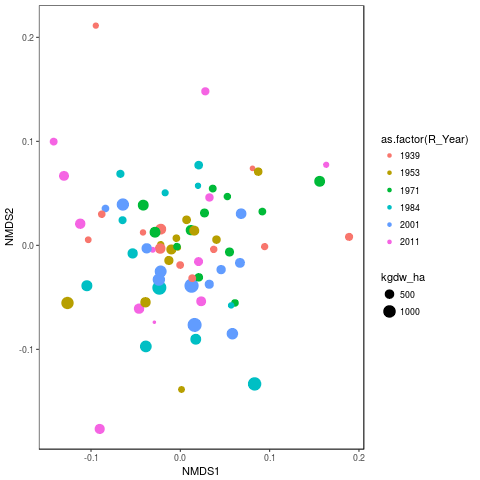

In [157]:
%%R
p.t1 = plot_ordination(physeq.plantT1, dist.bray.nmds, justDF = TRUE)


p = ggplot(p.t1,aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(color=as.factor(R_Year), size = kgdw_ha)) +
    theme_pub()
        
p

In [158]:
%%R
ordMean = p.t1 %>% 
    group_by(Genotype, R_Year) %>%
    summarize(mAxis.1 = mean(NMDS1),
                seAxis.1 = sd(NMDS1)/sqrt(length(NMDS1)),
             mAxis.2 = mean(NMDS2), 
             seAxis.2 = sd(NMDS2)/sqrt(length(NMDS2)))




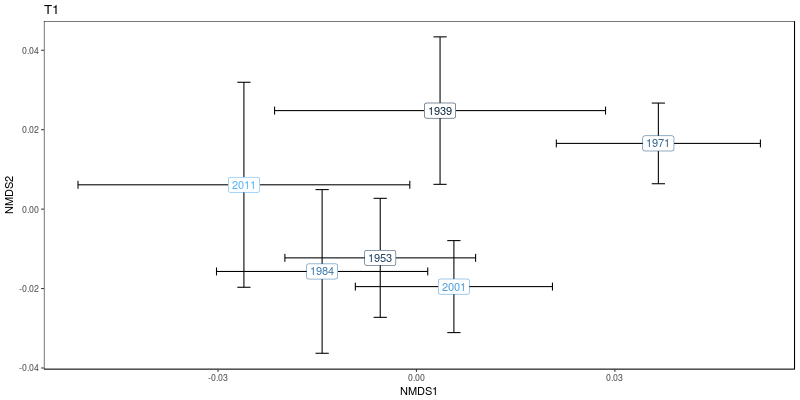

In [159]:
%%R -w 800 -h 400
pT1 = ggplot(ordMean, aes(x = mAxis.1, y = mAxis.2, label = R_Year)) +
    geom_point()+
    theme_pub()+
    geom_errorbar(aes(ymin = mAxis.2 - seAxis.2, ymax = mAxis.2 + seAxis.2),      
                color = "black",
                width = .002) +
    geom_errorbarh(aes(xmin = mAxis.1 - seAxis.1, xmax = mAxis.1 + seAxis.1),color = "black",
                height = .002)+
    geom_label(aes(color = R_Year), check_overlap = TRUE) +
    theme(legend.position = "none")+
    xlab("NMDS1")+
    ylab("NMDS2")+
   # facet_wrap(~Fert)+
    ggtitle("T1")

pT1

### Mantel of T1 

In [160]:
%%R

#Test on soil activity/rhizosphere effect
Sd = sample_data(physeq.plantT1)

# Generate distance matrix of year of release
Yd = dist(Sd[,"R_Year"], method = "euclidian")
#hist(Yd)

# generate distance matrix of rep and change all values > 1 to 1
Rd = dist(Sd[,"Rep"])
Rd[Rd > 1] <- 1


M1 = mantel.partial(T1.bray.dist, Yd, Rd, method="pearson", permutations=999)
M1 %>% print

M2 =  mantel.partial(T1.wunif.dist, Yd, Rd, method="pearson", permutations=999)
M2 %>% print
#Model is not significant within T3


Partial Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel.partial(xdis = T1.bray.dist, ydis = Yd, zdis = Rd, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.07992 
      Significance: 0.023 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0479 0.0643 0.0745 0.0912 
Permutation: free
Number of permutations: 999


Partial Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel.partial(xdis = T1.wunif.dist, ydis = Yd, zdis = Rd, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.06282 
      Significance: 0.065 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0543 0.0671 0.0796 0.0926 
Permutation: free
Number of permutations: 999



##  T2 ADONIS

In [161]:
%%R
# subset phyloseq object
physeq.plantT2 = subset_samples(physeq,  Planted == "Rhizosphere" & TimePoint == "T2" & SeedTreatment == "Treated")
physeq.plantT2

# create unifrac distance matrix
registerDoParallel(cores=28)
T2.wunif.dist = distance(physeq.plantT2, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

T2.bray.dist = distance(physeq.plantT2, 
                      method = "bray", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [162]:
%%R
set.seed(101)


df = as(sample_data(physeq.plantT2), "data.frame")

print("Bray-Curtis")
d = T2.bray.dist
T2adonis = adonis(formula = d ~ Rep + Genotype, df, permutations = 999)
T2adonis %>% print

print("w-UniFrac")
d = T2.wunif.dist
T2adonis = adonis(formula = d ~ Rep + Genotype, df, permutations = 999)
T2adonis


[1] "Bray-Curtis"

Call:
adonis(formula = d ~ Rep + Genotype, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Rep        3   0.23615 0.078717   2.054 0.12000  0.001 ***
Genotype  11   0.46708 0.042462   1.108 0.23735  0.039 *  
Residuals 33   1.26467 0.038323         0.64265           
Total     47   1.96790                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "w-UniFrac"

Call:
adonis(formula = d ~ Rep + Genotype, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)    
Rep        3  0.031581 0.0105269  3.1315 0.16598  0.001 ***
Genotype  11  0.047754 0.0043413  1.2914 0.25098  0.024 *  
Residuals 33  0.110935 0.0033617         0.58304           
Total     47  0.190270          

* Genotype has a significant effect on community composition at R1, but ADONIS is not significant for R_Year

## T2 ordination 

In [163]:
%%R
##Calculating wunifrac distances

#dist.unif = distance(ps, method = "weighted_unifrac")

## Taking distance matrix and making NNMDS rank values with vegan function metaMDS
### k = dimensions (usually 2 or 3 used), trymax can give more attempts to reach solution than the default that phyloseq uses

dist.bray.nmds = metaMDS(T2.bray.dist,autotransform=F,k=3,trymax=50)




Run 0 stress 0.111785 
Run 1 stress 0.111786 
... Procrustes: rmse 0.0005269393  max resid 0.002701488 
... Similar to previous best
Run 2 stress 0.1117869 
... Procrustes: rmse 0.0005494032  max resid 0.002695254 
... Similar to previous best
Run 3 stress 0.1117856 
... Procrustes: rmse 0.0003200912  max resid 0.001288098 
... Similar to previous best
Run 4 stress 0.111785 
... New best solution
... Procrustes: rmse 0.0003985006  max resid 0.00205871 
... Similar to previous best
Run 5 stress 0.1187453 
Run 6 stress 0.1117855 
... Procrustes: rmse 0.0005935915  max resid 0.002320255 
... Similar to previous best
Run 7 stress 0.111785 
... Procrustes: rmse 0.0004214552  max resid 0.00176901 
... Similar to previous best
Run 8 stress 0.111789 
... Procrustes: rmse 0.001152439  max resid 0.005196215 
... Similar to previous best
Run 9 stress 0.1117852 
... Procrustes: rmse 0.0005795116  max resid 0.002854013 
... Similar to previous best
Run 10 stress 0.1117873 
... Procrustes: rmse 0.00

In [164]:
%%R
#Plot NMDS

p = plot_ordination(physeq.plantT2, dist.bray.nmds, justDF = TRUE)


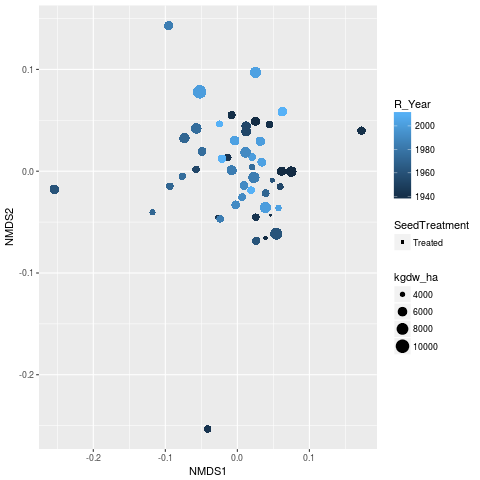

In [165]:
%%R

p1 = ggplot(p,aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(color=R_Year, shape = SeedTreatment, size = kgdw_ha))
        
p1

In [166]:
%%R
ordMean = p %>% 
    group_by(Genotype, R_Year) %>%
    summarize(mAxis.1 = mean(NMDS1),
                seAxis.1 = sd(NMDS1)/sqrt(length(NMDS1)),
             mAxis.2 = mean(NMDS2), 
             seAxis.2 = sd(NMDS2)/sqrt(length(NMDS2)))




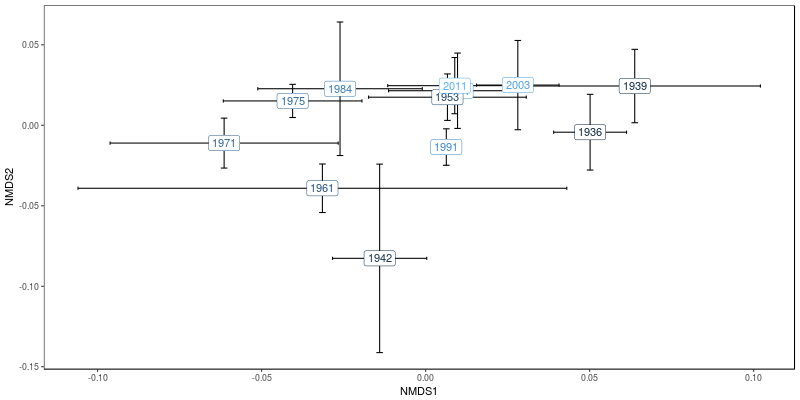

In [167]:
%%R -w 800 -h 400
ggplot(ordMean, aes(x = mAxis.1, y = mAxis.2, label = R_Year)) +
    geom_point()+
    theme_pub()+
    geom_errorbar(aes(ymin = mAxis.2 - seAxis.2, ymax = mAxis.2 + seAxis.2),      
                color = "black",
                width = .002) +
    geom_errorbarh(aes(xmin = mAxis.1 - seAxis.1, xmax = mAxis.1 + seAxis.1),color = "black",
                height = .002)+
    geom_label(aes(color = R_Year), check_overlap = TRUE) +
    theme(legend.position = "none")+
    xlab("NMDS1")+
    ylab("NMDS2")

In [168]:
%%R
filter(p, NMDS2 < -0.2 | NMDS1 < -0.2)

        NMDS1       NMDS2     X.sampleID TubeID ExtractionPlate PooledDNAPlate
1 -0.04125156 -0.25324060 ERA-T2_1-4c_85    380            ERA1              A
2 -0.25419760 -0.01785013 ERA-T2_4-4d_85    474            ERA4              B
  Sample.Well.ID PrimerPlate Primer.Number Primer.Well.ID  X primerFwdLoc
1             E6           1            45             E6 NA          1-E
2             C1           2             3             C1 NA          2-C
  primerRevLoc fwd_barcode rev_barcode  PlotID TimePoint Rep Row Pos Fert
1          1-6    TCATCGAG    CTACGCAG 1-4c_85        T2   1   4   c   85
2          2-1    AGAGTCAC    AACTCTCG 4-4d_85        T2   4   4   d   85
  PlotIndex Plant Genotype SeedTreatment R_Year ERA BG_activity.g BX_activity.g
1        44   339      339       Treated   1942   1      88.21732      19.60371
2       226  3618     3618       Treated   1961   2      76.78400      19.61642
  CB_activity.g LAP_activity.g NAG_activity.g Stage kgdw_ha FracN.leco
1      2

## T2 without outliers

In [169]:
%%R
# subset phyloseq object
physeq.plantT2 = subset_samples(physeq,  
            Planted == "Rhizosphere" & TimePoint == "T2" & SeedTreatment == "Treated") #& !X.sampleID %in% 
                              #  c("ERA-T2_1-4c_85", "ERA-T2_4-4d_85"))


# create unifrac distance matrix
registerDoParallel(cores=28)
T2.wunif.dist = distance(physeq.plantT2, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

T2.bray.dist = distance(physeq.plantT2, 
                      method = "bray", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [170]:
%%R
set.seed(101)


df = as(sample_data(physeq.plantT2), "data.frame")

print("Bray-Curtis")
d = T2.bray.dist
T2adonis = adonis(formula = d ~ Rep + Genotype, df, permutations = 999)
T2adonis %>% print

print("w-UniFrac")
d = T2.wunif.dist
T2adonis = adonis(formula = d ~ Rep + Genotype, df, permutations = 999)
T2adonis

[1] "Bray-Curtis"

Call:
adonis(formula = d ~ Rep + Genotype, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Rep        3   0.23615 0.078717   2.054 0.12000  0.001 ***
Genotype  11   0.46708 0.042462   1.108 0.23735  0.039 *  
Residuals 33   1.26467 0.038323         0.64265           
Total     47   1.96790                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "w-UniFrac"

Call:
adonis(formula = d ~ Rep + Genotype, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)    
Rep        3  0.031581 0.0105269  3.1315 0.16598  0.001 ***
Genotype  11  0.047754 0.0043413  1.2914 0.25098  0.024 *  
Residuals 33  0.110935 0.0033617         0.58304           
Total     47  0.190270          

### Ordinate T2 with nmds

In [171]:
%%R
## Taking distance matrix and making NNMDS rank values with vegan function metaMDS
### k = dimensions (usually 2 or 3 used), trymax can give more attempts to reach solution than the default that phyloseq uses

dist.bray.nmds = metaMDS(T2.bray.dist,autotransform=F,k=3,trymax=50)



Run 0 stress 0.111785 
Run 1 stress 0.111786 
... Procrustes: rmse 0.0005269393  max resid 0.002701488 
... Similar to previous best
Run 2 stress 0.1117869 
... Procrustes: rmse 0.0005494032  max resid 0.002695254 
... Similar to previous best
Run 3 stress 0.1117856 
... Procrustes: rmse 0.0003200912  max resid 0.001288098 
... Similar to previous best
Run 4 stress 0.111785 
... New best solution
... Procrustes: rmse 0.0003985006  max resid 0.00205871 
... Similar to previous best
Run 5 stress 0.1187453 
Run 6 stress 0.1117855 
... Procrustes: rmse 0.0005935915  max resid 0.002320255 
... Similar to previous best
Run 7 stress 0.111785 
... Procrustes: rmse 0.0004214552  max resid 0.00176901 
... Similar to previous best
Run 8 stress 0.111789 
... Procrustes: rmse 0.001152439  max resid 0.005196215 
... Similar to previous best
Run 9 stress 0.1117852 
... Procrustes: rmse 0.0005795116  max resid 0.002854013 
... Similar to previous best
Run 10 stress 0.1117873 
... Procrustes: rmse 0.00

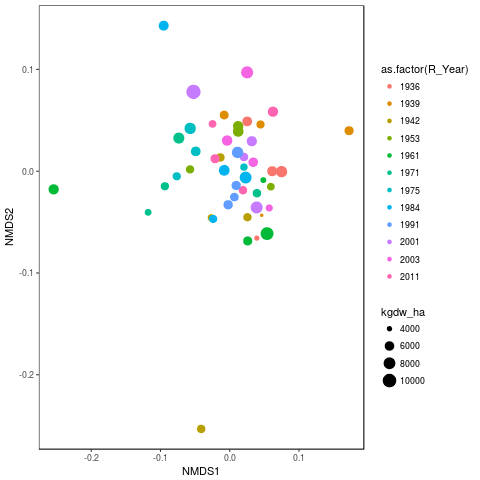

In [172]:
%%R
p.t2 = plot_ordination(physeq.plantT2, dist.bray.nmds, justDF = TRUE)


p = ggplot(p.t2,aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(color=as.factor(R_Year), size = kgdw_ha)) +
    theme_pub()
        
p

In [173]:
%%R
ordMean = p.t2 %>% 
    group_by(Genotype, R_Year) %>%
    summarize(mAxis.1 = mean(NMDS1),
                seAxis.1 = sd(NMDS1)/sqrt(length(NMDS1)),
             mAxis.2 = mean(NMDS2), 
             seAxis.2 = sd(NMDS2)/sqrt(length(NMDS2)))




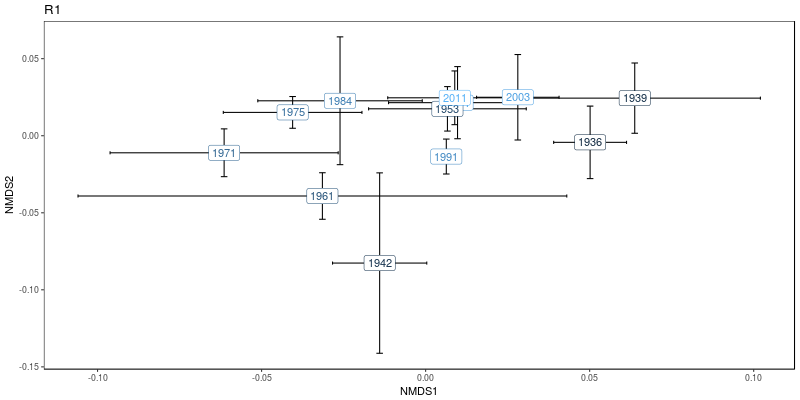

In [174]:
%%R -w 800 -h 400
pT2 = ggplot(ordMean, aes(x = mAxis.1, y = mAxis.2, label = R_Year)) +
    geom_point()+
    theme_pub()+
    geom_errorbar(aes(ymin = mAxis.2 - seAxis.2, ymax = mAxis.2 + seAxis.2),      
                color = "black",
                width = .002) +
    geom_errorbarh(aes(xmin = mAxis.1 - seAxis.1, xmax = mAxis.1 + seAxis.1),color = "black",
                height = .002)+
    geom_label(aes(color = R_Year), check_overlap = TRUE) +
    theme(legend.position = "none")+
    xlab("NMDS1")+
    ylab("NMDS2")+
    ggtitle("R1")
pT2

* Is there a curvilinear relationship?

* Careful whether or not using outliers 

## Curvilinear relationship between year of release and MCC?

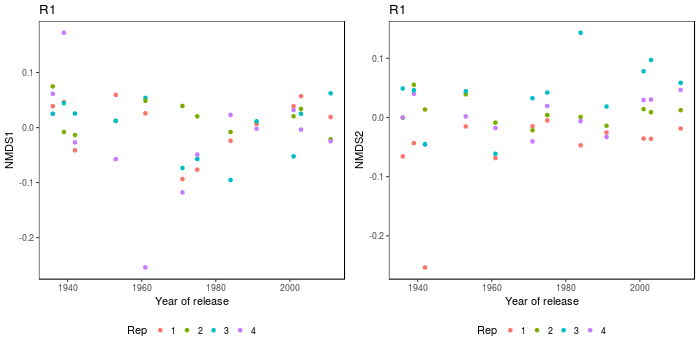

In [175]:
%%R -w 700 -h 350
p1 = ggplot(p.t2, aes(x = R_Year, y = NMDS1)) +
    geom_point(aes(color =Rep))+
    theme_pub()+
#     geom_errorbar(aes(ymin = mAxis.2 - seAxis.2, ymax = mAxis.2 + seAxis.2),      
#                 color = "black",
#                 width = .002) +
#     geom_errorbarh(aes(xmin = mAxis.1 - seAxis.1, xmax = mAxis.1 + seAxis.1),color = "black",
#                 height = .002)+
#    geom_label(aes(color = R_Year), check_overlap = TRUE) +
    theme(legend.position = "bottom")+
    xlab("Year of release")+
    ylab("NMDS1")+
    ggtitle("R1")

p2 = ggplot(p.t2, aes(x = R_Year, y = NMDS2)) +
    geom_point(aes(color = Rep))+
    theme_pub()+
#     geom_errorbar(aes(ymin = mAxis.2 - seAxis.2, ymax = mAxis.2 + seAxis.2),      
#                 color = "black",
#                 width = .002) +
#     geom_errorbarh(aes(xmin = mAxis.1 - seAxis.1, xmax = mAxis.1 + seAxis.1),color = "black",
#                 height = .002)+
#    geom_label(aes(color = R_Year), check_overlap = TRUE) +
    theme(legend.position = "bottom")+
    xlab("Year of release")+
    ylab("NMDS2")+
    ggtitle("R1")
grid.arrange(p1, p2, ncol =2)

* hmm, movement along axis 1 is interesting, try in PCoA

In [176]:
%%R
pcoa = ordinate(physeq.plantT2, 
                method = "PCoA", 
                distance = T2.bray.dist)

p = plot_ordination(physeq, pcoa, justDF = TRUE)


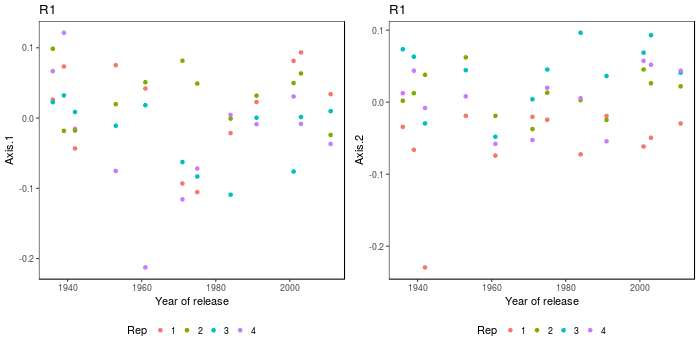

In [177]:
%%R -w 700 -h 350
p1 = ggplot(p, aes(x = R_Year, y = Axis.1)) +
    geom_point(aes(color =Rep))+
    theme_pub()+
#     geom_errorbar(aes(ymin = mAxis.2 - seAxis.2, ymax = mAxis.2 + seAxis.2),      
#                 color = "black",
#                 width = .002) +
#     geom_errorbarh(aes(xmin = mAxis.1 - seAxis.1, xmax = mAxis.1 + seAxis.1),color = "black",
#                 height = .002)+
#    geom_label(aes(color = R_Year), check_overlap = TRUE) +
    theme(legend.position = "bottom")+
    xlab("Year of release")+
    ylab("Axis.1")+
    ggtitle("R1")

p2 = ggplot(p, aes(x = R_Year, y = Axis.2)) +
    geom_point(aes(color = Rep))+
    theme_pub()+
#     geom_errorbar(aes(ymin = mAxis.2 - seAxis.2, ymax = mAxis.2 + seAxis.2),      
#                 color = "black",
#                 width = .002) +
#     geom_errorbarh(aes(xmin = mAxis.1 - seAxis.1, xmax = mAxis.1 + seAxis.1),color = "black",
#                 height = .002)+
#    geom_label(aes(color = R_Year), check_overlap = TRUE) +
    theme(legend.position = "bottom")+
    xlab("Year of release")+
    ylab("Axis.2")+
    ggtitle("R1")
grid.arrange(p1, p2, ncol =2)

### plot of merged samples

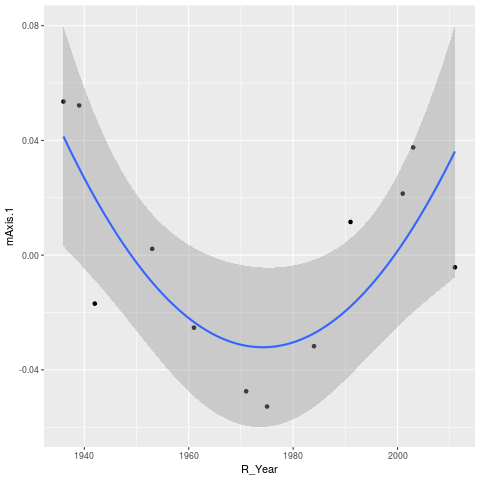

In [178]:
%%R
tmp = p %>% group_by(R_Year) %>%
    summarize(mAxis.1 = mean(Axis.1),
                seAxis.1 = sd(Axis.1)/sqrt(length(Axis.1))) 
    ggplot(tmp, aes(x = R_Year, y = mAxis.1)) +
    geom_point() +
    stat_smooth(method = "lm", formula = y ~ poly(x,2))

In [179]:
%%R
m = lm(mAxis.1~poly(R_Year,2), data = tmp)
anova(m)
summary(m)


Call:
lm(formula = mAxis.1 ~ poly(R_Year, 2), data = tmp)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.040398 -0.017086  0.004872  0.018498  0.029450 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)   
(Intercept)       2.945e-17  7.707e-03   0.000  1.00000   
poly(R_Year, 2)1 -1.787e-02  2.670e-02  -0.669  0.52008   
poly(R_Year, 2)2  8.866e-02  2.670e-02   3.321  0.00893 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0267 on 9 degrees of freedom
Multiple R-squared:  0.5604,	Adjusted R-squared:  0.4627 
F-statistic: 5.737 on 2 and 9 DF,  p-value: 0.02475



* but axis 1 only accounts for 10% of the variation in MCC

In [180]:
%%R
# on raw data
m = lmer(Axis.1~poly(R_Year,2) + (1|Rep), data = p)
anova(m)
summary(m)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: Axis.1 ~ poly(R_Year, 2) + (1 | Rep)
   Data: p

REML criterion at convergence: -120.9

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.94057 -0.69122  0.09372  0.65170  1.85402 

Random effects:
 Groups   Name        Variance  Std.Dev.
 Rep      (Intercept) 0.0005194 0.02279 
 Residual             0.0034177 0.05846 
Number of obs: 48, groups:  Rep, 4

Fixed effects:
                   Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)       3.246e-17  1.418e-02  3.000e+00   0.000  1.00000   
poly(R_Year, 2)1 -3.574e-02  5.846e-02  4.200e+01  -0.611  0.54425   
poly(R_Year, 2)2  1.773e-01  5.846e-02  4.200e+01   3.033  0.00414 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) p(R_Y,2)1
ply(R_Y,2)1 0.000           
ply(R_Y,2)2 0.000  0.000    


In [181]:
%%R
r.squaredGLMM(m)

      R2m       R2c 
0.1502439 0.2623475 


### Mantel test at T2

In [182]:
%%R

#Test on soil activity/rhizosphere effect
Sd = sample_data(physeq.plantT2)

# Generate distance matrix of year of release
Yd = dist(Sd[,"R_Year"], method = "euclidian")
#hist(Yd)

# generate distance matrix of rep and change all values > 1 to 1
Rd = dist(Sd[,"Rep"])
Rd[Rd > 1] <- 1


M1 = mantel.partial(T2.bray.dist, Yd, Rd, method="pearson", permutations=999)
M1 %>% print

M2 =  mantel.partial(T2.wunif.dist, Yd, Rd, method="pearson", permutations=999)
M2 %>% print
#Model is not significant within T2


Partial Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel.partial(xdis = T2.bray.dist, ydis = Yd, zdis = Rd, method = "pearson",      permutations = 999) 

Mantel statistic r: -0.01635 
      Significance: 0.632 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0729 0.0947 0.1098 0.1255 
Permutation: free
Number of permutations: 999


Partial Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel.partial(xdis = T2.wunif.dist, ydis = Yd, zdis = Rd, method = "pearson",      permutations = 999) 

Mantel statistic r: -0.03173 
      Significance: 0.718 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0708 0.0888 0.1013 0.1191 
Permutation: free
Number of permutations: 999



## T3

In [183]:
%%R
# subset phyloseq object
physeq.plantT3 = subset_samples(physeq,  Planted == "Rhizosphere" & TimePoint == "T3")
physeq.plantT3

# create unifrac distance matrix
registerDoParallel(cores=28)
T3.wunif.dist = distance(physeq.plantT3, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

T3.bray.dist = distance(physeq.plantT3, 
                      method = "bray", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


In [184]:
%%R
set.seed(101)

df = as(sample_data(physeq.plantT3), "data.frame")
d = T3.bray.dist
print("Bray-curtis")
T3adonis = adonis(formula = d ~ Rep + Fert + Genotype, df, permutations = 999)
T3adonis %>% print

print("")
print("weighted UniFrac")
d = T3.wunif.dist
T3adonis = adonis(formula = d ~ Rep + Fert + Genotype, df, permutations = 999)
T3adonis

[1] "Bray-curtis"

Call:
adonis(formula = d ~ Rep + Fert + Genotype, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Rep        3   0.28311 0.094369  2.4104 0.09244  0.001 ***
Fert       2   0.14436 0.072180  1.8436 0.04714  0.001 ***
Genotype   5   0.24687 0.049374  1.2611 0.08061  0.003 ** 
Residuals 61   2.38822 0.039151         0.77981           
Total     71   3.06256                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] ""
[1] "weighted UniFrac"

Call:
adonis(formula = d ~ Rep + Fert + Genotype, data = df, permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)    
Rep        3  0.037782 0.0125939  3.5287 0.12678  0.001 ***
Fert       2  0.019665 0.0098326  2.7550 0.06599  0.002 ** 
Genot

* Genotype is significant at T3 when interaction term is not included.  However it describes a lower portion of variance than the untransformed data

### Ordinate T3 with nmds

In [185]:
%%R
## Taking distance matrix and making NNMDS rank values with vegan function metaMDS
### k = dimensions (usually 2 or 3 used), trymax can give more attempts to reach solution than the default that phyloseq uses

dist.bray.nmds = metaMDS(T3.bray.dist,autotransform=F,k=3,trymax=50)



Run 0 stress 0.1473899 
Run 1 stress 0.1569636 
Run 2 stress 0.1473673 
... New best solution
... Procrustes: rmse 0.003760486  max resid 0.02582854 
Run 3 stress 0.1473711 
... Procrustes: rmse 0.0008952669  max resid 0.006139439 
... Similar to previous best
Run 4 stress 0.1524353 
Run 5 stress 0.1552956 
Run 6 stress 0.1512119 
Run 7 stress 0.1554566 
Run 8 stress 0.1473697 
... Procrustes: rmse 0.000345603  max resid 0.001677542 
... Similar to previous best
Run 9 stress 0.1524955 
Run 10 stress 0.1557548 
Run 11 stress 0.1473878 
... Procrustes: rmse 0.0034524  max resid 0.02425225 
Run 12 stress 0.147367 
... New best solution
... Procrustes: rmse 6.681269e-05  max resid 0.0003625797 
... Similar to previous best
Run 13 stress 0.1473952 
... Procrustes: rmse 0.004312048  max resid 0.02989764 
Run 14 stress 0.151205 
Run 15 stress 0.1473712 
... Procrustes: rmse 0.0009645655  max resid 0.004619814 
... Similar to previous best
Run 16 stress 0.1473785 
... Procrustes: rmse 0.002569

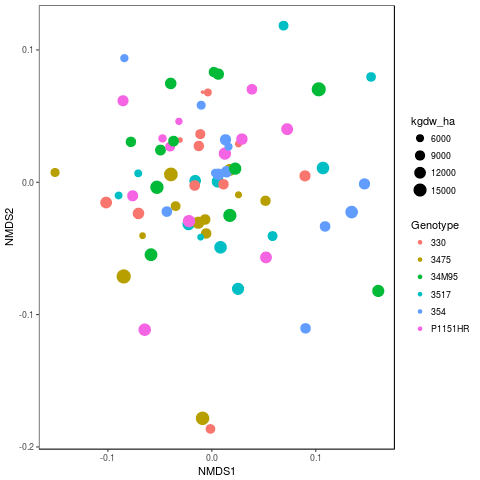

In [186]:
%%R
p.t3 = plot_ordination(physeq.plantT3, dist.bray.nmds, justDF = TRUE)


p2 = ggplot(p.t3,aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(color=Genotype, size = kgdw_ha)) +
    theme_pub()
        
p2

In [187]:
%%R
ordMean = p.t3 %>% 
    group_by(Genotype, R_Year) %>%
    summarize(mAxis.1 = mean(NMDS1),
                seAxis.1 = sd(NMDS1)/sqrt(length(NMDS1)),
             mAxis.2 = mean(NMDS2), 
             seAxis.2 = sd(NMDS2)/sqrt(length(NMDS2)))




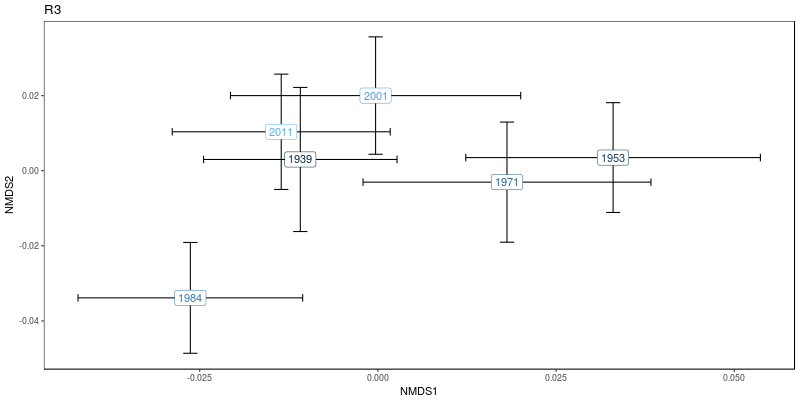

In [188]:
%%R -w 800 -h 400
pT3 = ggplot(ordMean, aes(x = mAxis.1, y = mAxis.2, label = R_Year)) +
    geom_point()+
    theme_pub()+
    geom_errorbar(aes(ymin = mAxis.2 - seAxis.2, ymax = mAxis.2 + seAxis.2),      
                color = "black",
                width = .002) +
    geom_errorbarh(aes(xmin = mAxis.1 - seAxis.1, xmax = mAxis.1 + seAxis.1),color = "black",
                height = .002)+
    geom_label(aes(color = R_Year), check_overlap = TRUE) +
    theme(legend.position = "none")+
    xlab("NMDS1")+
    ylab("NMDS2") +
    ggtitle("R3")
pT3

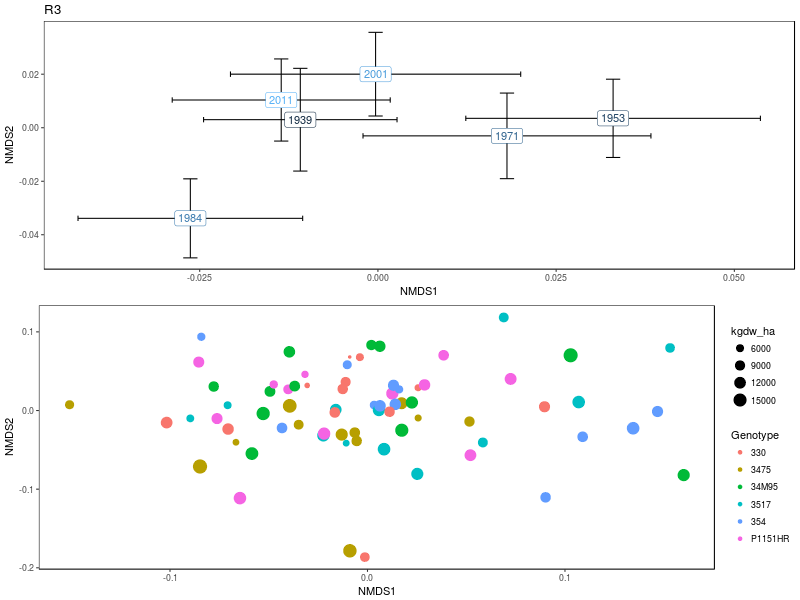

In [189]:
%%R -w 800 -h 600
grid.arrange(pT3, p2, ncol = 1)

### Mantel test at T3

In [190]:
%%R

#Test on soil activity/rhizosphere effect
Sd = sample_data(physeq.plantT3)

# Generate distance matrix of year of release
Yd = dist(Sd[,"R_Year"], method = "euclidian")
#hist(Yd)

# generate distance matrix of rep and change all values > 1 to 1
Rd = dist(Sd[,"Rep"])
Rd[Rd > 1] <- 1


M1 = mantel.partial(T3.bray.dist, Yd, Rd, method="pearson", permutations=999)
M1 %>% print

M2 =  mantel.partial(T3.wunif.dist, Yd, Rd, method="pearson", permutations=999)
M2 %>% print
#Model is not significant within T3


Partial Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel.partial(xdis = T3.bray.dist, ydis = Yd, zdis = Rd, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.02305 
      Significance: 0.293 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0546 0.0652 0.0820 0.0964 
Permutation: free
Number of permutations: 999


Partial Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel.partial(xdis = T3.wunif.dist, ydis = Yd, zdis = Rd, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.004601 
      Significance: 0.428 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0464 0.0605 0.0774 0.0895 
Permutation: free
Number of permutations: 999



# Plot  figures with grid.arrange

# CAP

In [191]:
%%R
# subset phyloseq object to just rhizosphere plants, time point 2 and only treated seeds
phy = subset_samples(physeq, Planted == "Rhizosphere" & TimePoint == "T2" & SeedTreatment == "Treated")
phy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 48 samples ]
sample_data() Sample Data:       [ 48 samples by 47 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [192]:
%%R
T2.wunif.dist = phyloseq::distance(phy, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [193]:
%%R
sample_data(phy) %>% colnames

 [1] "X.sampleID"      "TubeID"          "ExtractionPlate" "PooledDNAPlate" 
 [5] "Sample.Well.ID"  "PrimerPlate"     "Primer.Number"   "Primer.Well.ID" 
 [9] "X"               "primerFwdLoc"    "primerRevLoc"    "fwd_barcode"    
[13] "rev_barcode"     "PlotID"          "TimePoint"       "Rep"            
[17] "Row"             "Pos"             "Fert"            "PlotIndex"      
[21] "Plant"           "Genotype"        "SeedTreatment"   "R_Year"         
[25] "ERA"             "BG_activity.g"   "BX_activity.g"   "CB_activity.g"  
[29] "LAP_activity.g"  "NAG_activity.g"  "Stage"           "kgdw_ha"        
[33] "FracN.leco"      "FracC.leco"      "kgN_ha"          "RGR"            
[37] "AGR"             "Nprod"           "NupR"            "d15N"           
[41] "X15N_AtPercent"  "FracN"           "FracN_fromSoil"  "FracN_fromFert" 
[45] "kgFertN_ha"      "kgSoilN_ha"      "Planted"        


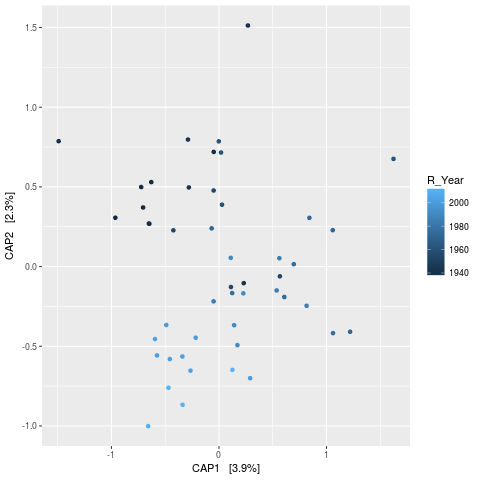

In [194]:
%%R
sample_data(phy)$Rep = as.factor(sample_data(phy)$Rep)
# cap.ord = ordinate(
#     physeq = phy, 
#     method = "CAP",
#     distance = T2.wunif.dist,
#     formula = ~ R_Year + Rep + Condition())

ordcap = ordinate(phy, "CAP", "bray", ~poly(R_Year,2) + Condition(Rep))
plot_ordination(phy, ordcap, "samples", color="R_Year")




# # CAP plot
# cap.plot <- plot_ordination(phy, cap.ord, axes = c(1,2)) + 
#     geom_point(aes(fill = Genotype), pch= 21,alpha= 1) 
    #geom_point(colour = "grey90", 
    #    size = 1.5) + 
    
    #scale_color_manual(values = c("#1CE6FF","#B79762", "#004D43", "#8FB0FF", "#997D87", "#5A0007"), name = "Genotype",
 #                      labels = c("B73xB97", "B73xTx303", "ECHES","FAGES","HELAN",     "SORSUD")) 




# Now add the environmental variables as arrows
# arrowmat <- vegan::scores(cap.ord, display = "bp")

# rownames(arrowmat) = c("R_Year", "Rep")
# #rownames(arrowmat) = c("BX", "CB", "LAP", "NAG")

# # Add labels, make a data.frame
# arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

# Define the arrow aesthetic mapping
# arrow_map <- aes(xend = CAP1, 
#     yend = CAP2, 
#     x = 0, 
#     y = 0, 
#     shape = NULL, 
#     color = NULL, 
#     label = labels)

# label_map <- aes(x = 1.3 * CAP1, 
#     y = 1.3 * CAP2, 
#     shape = NULL, 
#     color = NULL, 
#     label = labels)

# arrowhead = arrow(length = unit(0.02, "npc"))

# # Make a new graphic
# p = cap.plot + 
# geom_segment(arrow_map, 
#     size = .5, 
#     data = arrowdf, 
#     color = "gray", 
#     arrow = arrowhead
#     ) + 
# geom_text(label_map,   
#     data = arrowdf, 
#     show_guide = FALSE) 
# p = p + theme_pub() 
# #p = p + theme(panel.border = element_blank(), legend.position = "right", legend.text = element_text(size = 10)) 
# p = p + theme(legend.position = "left", legend.text = element_text()) 

#save legend for independent formatting
# g_legend<-function(a.gplot){
#     tmp <- ggplot_gtable(ggplot_build(a.gplot))
#     leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
#     legend <- tmp$grobs[[leg]]
#     legend
# }
# 

                        
#legend1 <- g_legend(p)

                     
# p =  p + theme(axis.line.x = element_line(color="black", size = 1),
#     axis.line.y = element_line(color="black", size = 1), legend.position = "left")
# p = p + theme(legend.position = "bottom")
# p

In [195]:
%%R
anova(ordcap)

Permutation test for capscale under reduced model
Permutation: free
Number of permutations: 999

Model: capscale(formula = OTU ~ poly(R_Year, 2) + Condition(Rep), data = data, distance = distance)
         Df SumOfSqs      F Pr(>F)   
Model     2  0.10804 1.3974  0.002 **
Residual 42  1.62371                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Finally try DESeq2

In [6]:
%%R 
# loading

phy.thresh = readRDS('ERA_thresh.rds')

#Subset to T2
phy.thresh = subset_samples(phy.thresh, TimePoint == "T2" & SeedTreatment == "Treated", TRUE)
phy.thresh

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 48 samples ]
sample_data() Sample Data:       [ 48 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [7]:
%%R
sample_data(phy.thresh)$Rep = as.factor(sample_data(phy.thresh)$Rep)
sample_data(phy.thresh)$Row = as.factor(sample_data(phy.thresh)$Row)
sample_data(phy.thresh)$Fert = as.factor(sample_data(phy.thresh)$Fert)
sample_data(phy.thresh)$ERA = as.factor(sample_data(phy.thresh)$ERA)
sample_data(phy.thresh)$R_Year.c = sample_data(phy.thresh)$R_Year - 1935

In [8]:
%%R
dds = phyloseq_to_deseq2(phy.thresh, ~Rep + poly(R_Year.c,2))
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print

/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: converting counts to integer mode

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: the design formula contains a numeric variable with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: estimating size factors

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: estimating dispersions

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: gene-wise dispersion estimates: 38 workers

  warning

[1] "Intercept"          "Rep1"               "Rep2"              
[4] "Rep3"               "Rep4"               "poly.R_Year.c..2.1"
[7] "poly.R_Year.c..2.2"


In [9]:
%%R
Year.x.res = results(d_dds, name="poly.R_Year.c..2.1", alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
summary(Year.x.res) 




out of 4589 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 0, 0% 
LFC < 0 (down)   : 0, 0% 
outliers [1]     : 0, 0% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [10]:
%%R
Year.x2.res = results(d_dds, name="poly.R_Year.c..2.2", alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
summary(Year.x2.res) 




out of 4589 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 2, 0.044% 
LFC < 0 (down)   : 11, 0.24% 
outliers [1]     : 0, 0% 
low counts [2]   : 2758, 60% 
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [12]:
%%R
t.df = tax_table(phy.thresh) %>% as.data.frame()
t.df = t.df %>% mutate(OTU = row.names(t.df)) 

In [13]:
%%R
DF = Year.x2.res
DF$OTU = rownames(DF)
DF = DF %>% as.data.frame()
DF = left_join(DF, t.df, by = "OTU")

In [15]:
%%R
DF %>%
filter(padj < 0.05) %>%
write.csv('/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_Year2.csv')

In [201]:
%%R
toKeep = Year.x2.res %>% as.data.frame %>% mutate(OTU = rownames(Year.x2.res)) %>% filter(padj < 0.05) %>% .$OTU

In [220]:
%%R
#use non-sqrt transformed relative abundances for clarity of interpretation

phy = readRDS('ERA_snorm.rds')

#Subset to T2
phy = subset_samples(phy, TimePoint == "T2" & SeedTreatment == "Treated", TRUE)
phy

ToPlot = phy %>%
        prune_taxa(toKeep, .) %>%
        psmelt()
        

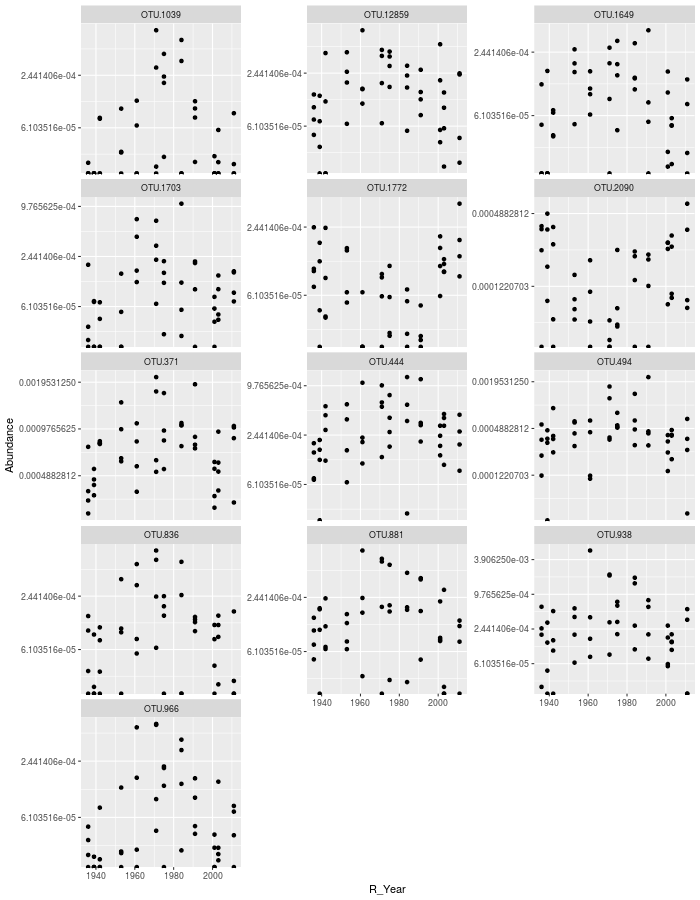

In [221]:
%%R -w 700 -h 900
require(scales)
p = ggplot(ToPlot, aes(x = R_Year, y = Abundance))+
       geom_point()+
     
       facet_wrap(~OTU, scales = "free_y", ncol = 3)+
        scale_y_continuous(trans=log2_trans())
p

In [222]:
%%R
ToPlot %>%
    select(OTU, Rank2, Rank3, Rank4, Rank5, Rank6, Rank7) %>%
    unique %>% print

PolyTaxa = ToPlot %>% .$OTU %>% unique

          OTU             Rank2                 Rank3                  Rank4
574   OTU.938  __Proteobacteria __Deltaproteobacteria         __Myxococcales
430   OTU.494  __Actinobacteria   __Micromonosporales   __Micromonosporaceae
320   OTU.371 __Verrucomicrobia    __OPB35_soil_group __uncultured_bacterium
371   OTU.444     __Chloroflexi      __Thermomicrobia         __JG30-KF-CM45
148  OTU.1703  __Proteobacteria __Deltaproteobacteria         __Myxococcales
511   OTU.881     __Chloroflexi      __Chloroflexales      __Chloroflexaceae
20   OTU.1039     __Chloroflexi        __Anaerolineae       __Anaerolineales
466   OTU.836     __Chloroflexi        __Anaerolineae       __Anaerolineales
96  OTU.12859   __Acidobacteria               __DA023 __uncultured_bacterium
616   OTU.966     __Chloroflexi        __Anaerolineae       __Anaerolineales
257  OTU.2090 __Verrucomicrobia      __Spartobacteria   __Chthoniobacterales
101  OTU.1649   __Bacteroidetes    __Sphingobacteriia   __Sphingobacteriales

In [229]:
%%R
mat = ToPlot %>%
    group_by(OTU, Rank2, Rank5, Rank6, Plant, R_Year) %>%
    summarize(mAbund = mean(Abundance)) %>%
    as.data.frame() %>%
       mutate(Taxa = paste(OTU, ":_", Rank5, "_", Rank6, sep = "")) %>%
    select(Taxa, R_Year, mAbund) %>%
    spread(R_Year,mAbund) 

rownames(mat) = mat$Taxa
mat = mat[,-1]
head(mat)
mat = data.matrix(mat, rownames.force = TRUE)
mat

                                                                  1936
OTU.1039:___Anaerolineaceae___uncultured                  6.069140e-06
OTU.12859:_NA_NA                                          9.012115e-05
OTU.1649:___Chitinophagaceae___Flavisolibacter            4.268263e-05
OTU.1703:___Sorangiineae___uncultured                     6.331621e-05
OTU.1772:___Planctomycetaceae___uncultured                1.299507e-04
OTU.2090:___DA101_soil_group___uncultured_bacterium       2.472435e-04
OTU.371:_NA_NA                                            4.387234e-04
OTU.444:___uncultured_bacterium_NA                        1.215739e-04
OTU.494:___Micromonospora_NA                              3.093907e-04
OTU.836:___Anaerolineaceae___uncultured                   7.010844e-05
OTU.881:___Roseiflexus___uncultured_Chloroflexi_bacterium 9.310028e-05
OTU.938:___Sorangiineae___uncultured                      2.653184e-04
OTU.966:___Anaerolineaceae___uncultured                   2.690137e-05
      

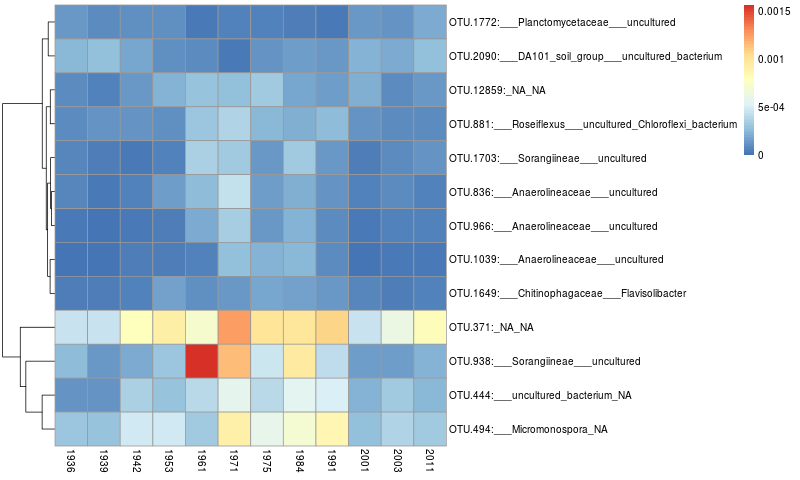

In [230]:
%%R -w 800
pheatmap::pheatmap(mat,
         cluster_col=FALSE)

## are these taxa rhizosphere responders or background?

In [209]:
%%R
l2f.rhiz = read.csv(file = "/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/BarevsHybrid.csv", header = TRUE)

In [210]:
%%R
mat = l2f.rhiz %>% filter(OTU %in% PolyTaxa & TimePoint == "T2") %>%
 select(OTU, Plant, log2FoldChange) %>%
    spread(Plant, log2FoldChange) %>%
    .[,c("OTU", "322","330"  ,   "339" ,    "354"   ,  "3618"  ,  "3517"  ,  "3541" ,   "3475" ,  
 "3394",    "34M95" ,  "34N42" ,  "P1151HR")]



In [211]:
%%R
rownames(mat) = mat$OTU
mat = mat[,-1]
head(mat)
mat = data.matrix(mat, rownames.force = TRUE)
mat

                 322        330         339         354       3618       3517
OTU.1039   0.2908125         NA  2.18205771  1.61656212  2.0510700  3.2540991
OTU.12859 -0.2397460 -0.5754415  0.38721026  1.11154761  1.5169609  1.4313313
OTU.1649  -0.5159308 -0.3407492 -0.21854781  1.06830720  0.7357834  0.9866756
OTU.1703   0.1534538 -0.3352692 -0.67550266 -0.07204963  2.5593706  2.3710454
OTU.1772  -0.5228727 -1.1074167 -0.71203634 -0.75595338 -2.7317692 -1.4725948
OTU.2090   0.6692167  0.7237254  0.37662535 -0.50265549 -0.4286481 -1.9297279
OTU.371   -0.1695206 -0.0257923  0.96797779  1.00239875  0.7180361  1.5250980
OTU.444   -0.4953284 -0.3602583  1.10514355  0.77263783  1.2268522  1.7480014
OTU.494    0.2290707  0.3247341  1.10276956  0.96659137  0.5220282  1.9066422
OTU.836    0.1369107 -0.6309979  0.01551551  1.00756768  1.9947083  2.6895855
OTU.881    1.0760508  1.4617163  1.87836357  1.31169583  2.9257842  3.0186452
OTU.938    0.4555728 -0.3795342  0.24484203  0.78325659  2.92366

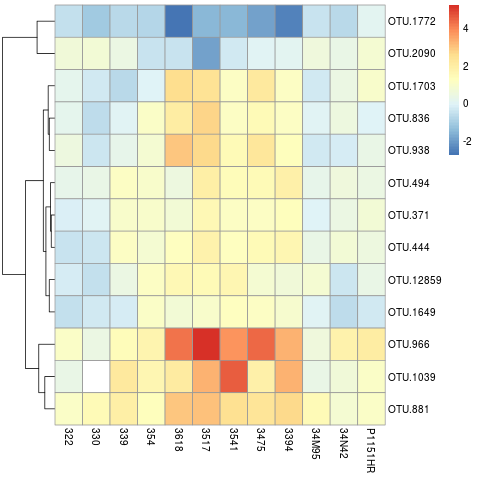

In [212]:
%%R
pheatmap::pheatmap(mat,
         cluster_col=FALSE)

In [213]:
%%R
Fert.sig = l2f.Fert %>% filter(padj < .05)
    Fert.sig %>% head %>% print
Rhiz.sig = l2f.rhiz %>% filter(p.adj < .05)


Error in eval(expr, envir, enclos) : object 'l2f.Fert' not found


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in eval(expr, envir, enclos) : object 'l2f.Fert' not found

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 1: Removed 1 rows containing non-finite values (stat_smooth). 

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 2: Removed 1 rows containing missing values (geom_point). 

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 3: Removed 1 rows containing missing values (geom_errorbar). 

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 4: 
  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In as

In [214]:
%%R
betas <- coef(d_dds)
colnames(betas)

[1] "Intercept"          "Rep1"               "Rep2"              
[4] "Rep3"               "Rep4"               "poly.R_Year.c..2.1"
[7] "poly.R_Year.c..2.2"


In [215]:
%%R
str(betas)

 num [1:4592, 1:7] 2.728 -0.989 3.925 1.453 -0.197 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:4592] "OTU.871" "OTU.9547" "OTU.523" "OTU.1107" ...
  ..$ : chr [1:7] "Intercept" "Rep1" "Rep2" "Rep3" ...


In [216]:
%%R
betas[topGenes,]


Error in withVisible({ : object 'topGenes' not found


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in withVisible({ : object 'topGenes' not found

  warnings.warn(x, RRuntimeWarning)


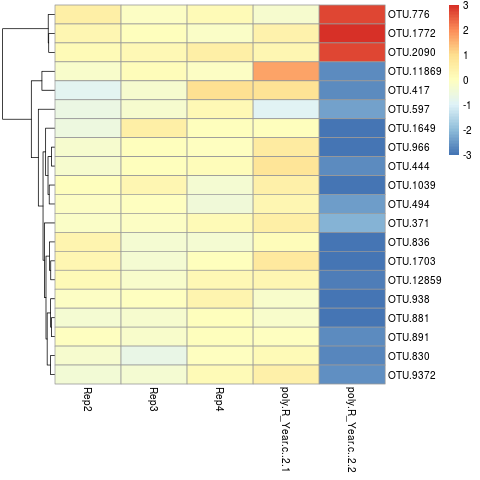

In [217]:
%%R
topGenes <- head(order(Year.x2.res$padj),20)
mat <- betas[topGenes, -c(1,2)]
thr <- 3 
mat[mat < -thr] <- -thr
mat[mat > thr] <- thr
pheatmap::pheatmap(mat, breaks=seq(from=-thr, to=thr, length=101),
         cluster_col=FALSE)

In [218]:
DF = results(d_dds)

supp = tax_table(phy.thresh)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

DF$Test = "R_Year"
        YR = DF

IndentationError: unexpected indent (<ipython-input-218-c9579624f00b>, line 4)

In [ ]:
%%R
sigtab = YR %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank4, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank4 = factor(as.character(sigtab$Rank4), levels=names(x))
# x = tapply(sigtab$log2FoldChange, sigtab$Rank3, function(x) max(x))
# x = sort(x, TRUE)
# sigtab$Rank3 = factor(as.character(sigtab$Rank3), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank4, y=log2FoldChange, size = baseMean)) + 
    geom_point(aes(color = Rank2))+
  theme_pub() +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("OTUs correlated with Year of Release")  +
   theme(legend.position="right")
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
    p2

In [ ]:
%%R
plotDispEsts(d_dds)

In [ ]:
%%R
DF = results(d_dds, contrast = c("ERA", "1", "3"))

supp = tax_table(phy.thresh)
            if (!setequal(row.names(supp), row.names(DF))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

DF$Test = "R_Year_poly1"
        RYear_poly1 = DF

In [ ]:
%%R
sigtab = RYear_poly1 %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank4, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank4 = factor(as.character(sigtab$Rank4), levels=names(x))
# x = tapply(sigtab$log2FoldChange, sigtab$Rank3, function(x) max(x))
# x = sort(x, TRUE)
# sigtab$Rank3 = factor(as.character(sigtab$Rank3), levels=names(x))
    
p2 = ggplot(sigtab, aes(x=Rank4, y=log2FoldChange, size = baseMean)) + 
    geom_point(aes(color = Rank2))+
  theme_pub() +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
    ggtitle("OTUs correlated with Year of Release")  +
   theme(legend.position="right")
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
    p2

In [ ]:
%%R
head(sigtab)

In [ ]:
%%R
library("vsn")
notAllZero <- (rowSums(counts(dds))>0)
meanSdPlot(log2(counts(dds,normalized=TRUE)[notAllZero,] + 1))

# Pseudomonas

In [ ]:
%%R
physeq.core %>% 
    tax_table() %>% 
    head()

In [ ]:
%%R
pdms = subset_taxa(physeq.snorm, Rank6=="__Pseudomonas") %>%
    subset_samples(Ntreat == "Nneg")
pdms

In [ ]:
%%R
title = "plot_bar; Pseudomonas-only"
plot_bar(pdms, "Genotype", "Abundance", title=title)

In [ ]:
%%R
pdms.mean = psmelt(pdms) %>%
        group_by(OTU,TimePoint, Genotype) %>%
         summarize(relAbundance = mean(Abundance))

In [ ]:
%%R -w 700 -h 700
ggplot(pdms.mean, aes(x = Genotype, y = relAbundance)) +
    geom_bar(stat = "identity") + 
    facet_grid(OTU~TimePoint, scales = "free_x")+
    theme(axis.text.x = element_text(angle = 60))
   # geom_text(aes(y = relAbundance + .001, label=sig))

In [ ]:
%%R
tax_table(pdms)

In [35]:
%%R
sessionInfo()

R version 3.3.2 (2016-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.2 LTS

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] stats4    parallel  tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] MuMIn_1.15.6               lsmeans_2.25-5            
 [3] estimability_1.2           lmerTest_2.0-33           
 [5] lme4_1.1-13                Matrix_1.2-8              
 [7] phyloseq_1.19.1            DESeq2_1.14.1             
 [9] SummarizedExperiment_1.4.0 Biobase_2.34.0            
[11] GenomicRanges_1.26.4       GenomeInfoDb_1.10.3       
[13] IRanges_2.8.2  